# Milestones 1
## Introduction
- Name: Izzan Dienurrahman
- Batch: HCK-003

## Objective
- Membuat model klasifikasi dengan hyperparameter yang sudah di optimasi untuk memprediksi apakah nasabah akan mengalami kredit macet.

## Problem Statements
- Meload dataset 
- Mengidentifikasi fitur/kolom yang kiranya berkaitan terhadap default_payment_next_month.
- Mengidentifikasi distribusi kolom-kolom pada dataset
- Menghandle missing value dan outlier
- Membuat pipeline untuk preprocessing dan training
- Mengevaluasi model
- Tuning hyperparameter model
- Mengevaluasi ulang model
- Menyimpan model

## SQL Command

>SELECT limit_balance, CAST(sex AS int64) AS sex, CAST(education_level AS int64) AS education_level, 
>CAST(marital_status AS int64) AS marital_status, age, pay_0, pay_2, pay_3, pay_4, 
>CAST(pay_5 AS float64) AS pay_5, CAST(pay_6 AS float64) AS pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS int64) AS default_payment_next_month
>FROM `bigquery-public-data.ml_datasets.credit_card_default` 
>LIMIT 5988

## Import Library

In [1]:
# import library yang dibutuhkan
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
import pandas as pd
import numpy  as np
import seaborn as sns; sns.set()
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import resample,shuffle
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Loading

In [2]:
# set max display column
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_csv('h8dsft_P1M1_Izzan.csv') # read csv insurance

In [4]:
df.head(10) # menampilkan 10 data teratas

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,0.0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
3,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
4,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0
5,500000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,0.0,155820.0,171565.0,184782.0,152365.0,139757.0,153348.0,20000.0,20241.0,20154.0,20019.0,20151.0,20037.0,0
6,50000.0,1,2,1,40.0,0.0,0.0,0.0,0.0,0.0,0.0,49073.0,49531.0,44002.0,44356.0,19344.0,19354.0,1691.0,1942.0,1296.0,674.0,693.0,1000.0,0
7,100000.0,1,5,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,94502.0,95697.0,98222.0,90500.0,82586.0,22620.0,5000.0,5000.0,3203.0,2103.0,50000.0,0.0,0
8,140000.0,1,2,1,29.0,0.0,0.0,0.0,0.0,0.0,0.0,130767.0,134946.0,130470.0,132038.0,131961.0,124256.0,6696.0,5000.0,4866.0,5300.0,5055.0,5000.0,0
9,50000.0,1,2,1,43.0,0.0,0.0,0.0,0.0,0.0,0.0,48919.0,48775.0,48731.0,48934.0,29116.0,28999.0,1800.0,2200.0,1400.0,582.0,580.0,30000.0,0


In [5]:
df.tail(10) # menampilkan 10 data terbawah

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,300000.0,2,2,1,28.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,16666.0,1000.0,16666.0,0.0,0.0,0.0,1000.0,16666.0,0.0,0.0,0.0,0.0,0
2956,200000.0,2,1,1,49.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,413.0,0.0,103.0,0.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,225.0,0
2957,50000.0,2,1,2,31.0,-1.0,0.0,-1.0,-1.0,-1.0,-2.0,12725.0,34526.0,12787.0,3995.0,0.0,0.0,30018.0,12787.0,3995.0,0.0,0.0,0.0,0
2958,50000.0,2,1,2,25.0,-1.0,-1.0,2.0,-1.0,-1.0,-2.0,13572.0,17983.0,15590.0,10610.0,0.0,0.0,5000.0,200.0,10610.0,0.0,0.0,0.0,0
2959,100000.0,2,1,2,37.0,-1.0,-1.0,0.0,-1.0,-1.0,-2.0,1725.0,21711.0,10487.0,780.0,0.0,0.0,21711.0,1000.0,780.0,0.0,0.0,0.0,0
2960,30000.0,2,3,2,50.0,-1.0,-1.0,2.0,-1.0,-1.0,-2.0,178.0,1860.0,940.0,1110.0,0.0,0.0,1860.0,0.0,1110.0,0.0,0.0,0.0,1
2961,20000.0,2,1,2,25.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,2650.0,0.0,855.0,640.0,0.0,0.0,0.0,855.0,640.0,0.0,0.0,2742.0,0
2962,280000.0,2,1,2,52.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,886.0,0.0,930.0,0.0,0.0,0.0,0.0,930.0,0.0,0.0,0.0,0.0,0
2963,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2964,100000.0,2,1,2,30.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,430.0,35993.0,2772.0,0.0,0.0,0.0,35993.0,2772.0,0.0,0.0,0.0,0.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Terdapat 2965 entri data, sekilas tidak ada standard missing values. Untuk type juga datanya sudah sesuai yakni numerikal semua.

In [7]:
df.isnull().sum() # menampilkan standar missing value

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Tidak ada standard missing value.

In [8]:
df.duplicated().sum()

1

Terdapat 1 entri data duplikat

In [9]:
# drop data duplikat
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

Data duplikat sudah tiada.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   marital_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 

Entri data tanpa duplikat dan missing value sejumlah 2964 baris.

# Exploratory Data Analysis (EDA)

In [12]:
df.head(3)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,0.0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0


Dataset terdiri dari fitur numerikal dan targetnya berupa data numerikal yang sudah di encode menjadi bentuk binary. Kategori target klasifikasi adalah apakah seseorang akan gagal bayar atau tidak pada bulan berikutnya. Menurut [sumber dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-izzan&ws=!1m9!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default!1m3!8m2!1s291779957624!2sc1037afa9997464c99b066deab08670b), nilai 0 yang artinya false (tidak gagal bayar) dan 1 artinya true (gagal bayar).

In [13]:
num_col = df.select_dtypes('number').columns.to_list()
len(num_col)

24

Terdapat 24 kolom pada dataset, dimana 23 nya adalah fitur dan 1 kolom default_payment_next month adalah target.

In [14]:
df.default_payment_next_month.unique()

array([0, 1])

Data target (default_payment_next_month) memiliki 2 unique values.

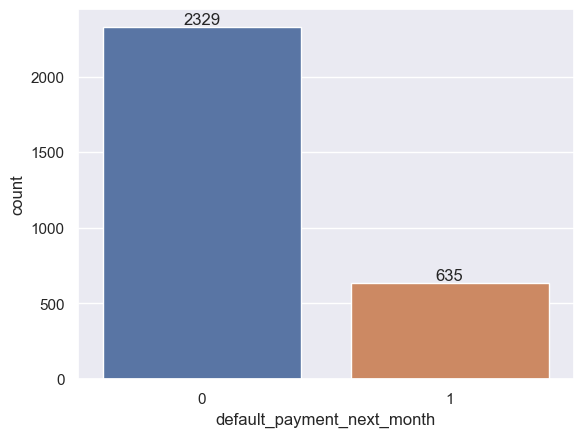

In [15]:
ax = sns.countplot(x=df.default_payment_next_month, data=df)
ax.bar_label(ax.containers[0])
plt.show()

Terlihat bahwa dataset memiliki `class imbalance`, dimana target label 0 berjumlah 2329 sedangkan target label 1 memiliki jumlah 635

In [16]:
# construct titles for plotting
titles = []
for i in range(len(num_col)):
    titles.append('Distribusi ' + num_col[i])

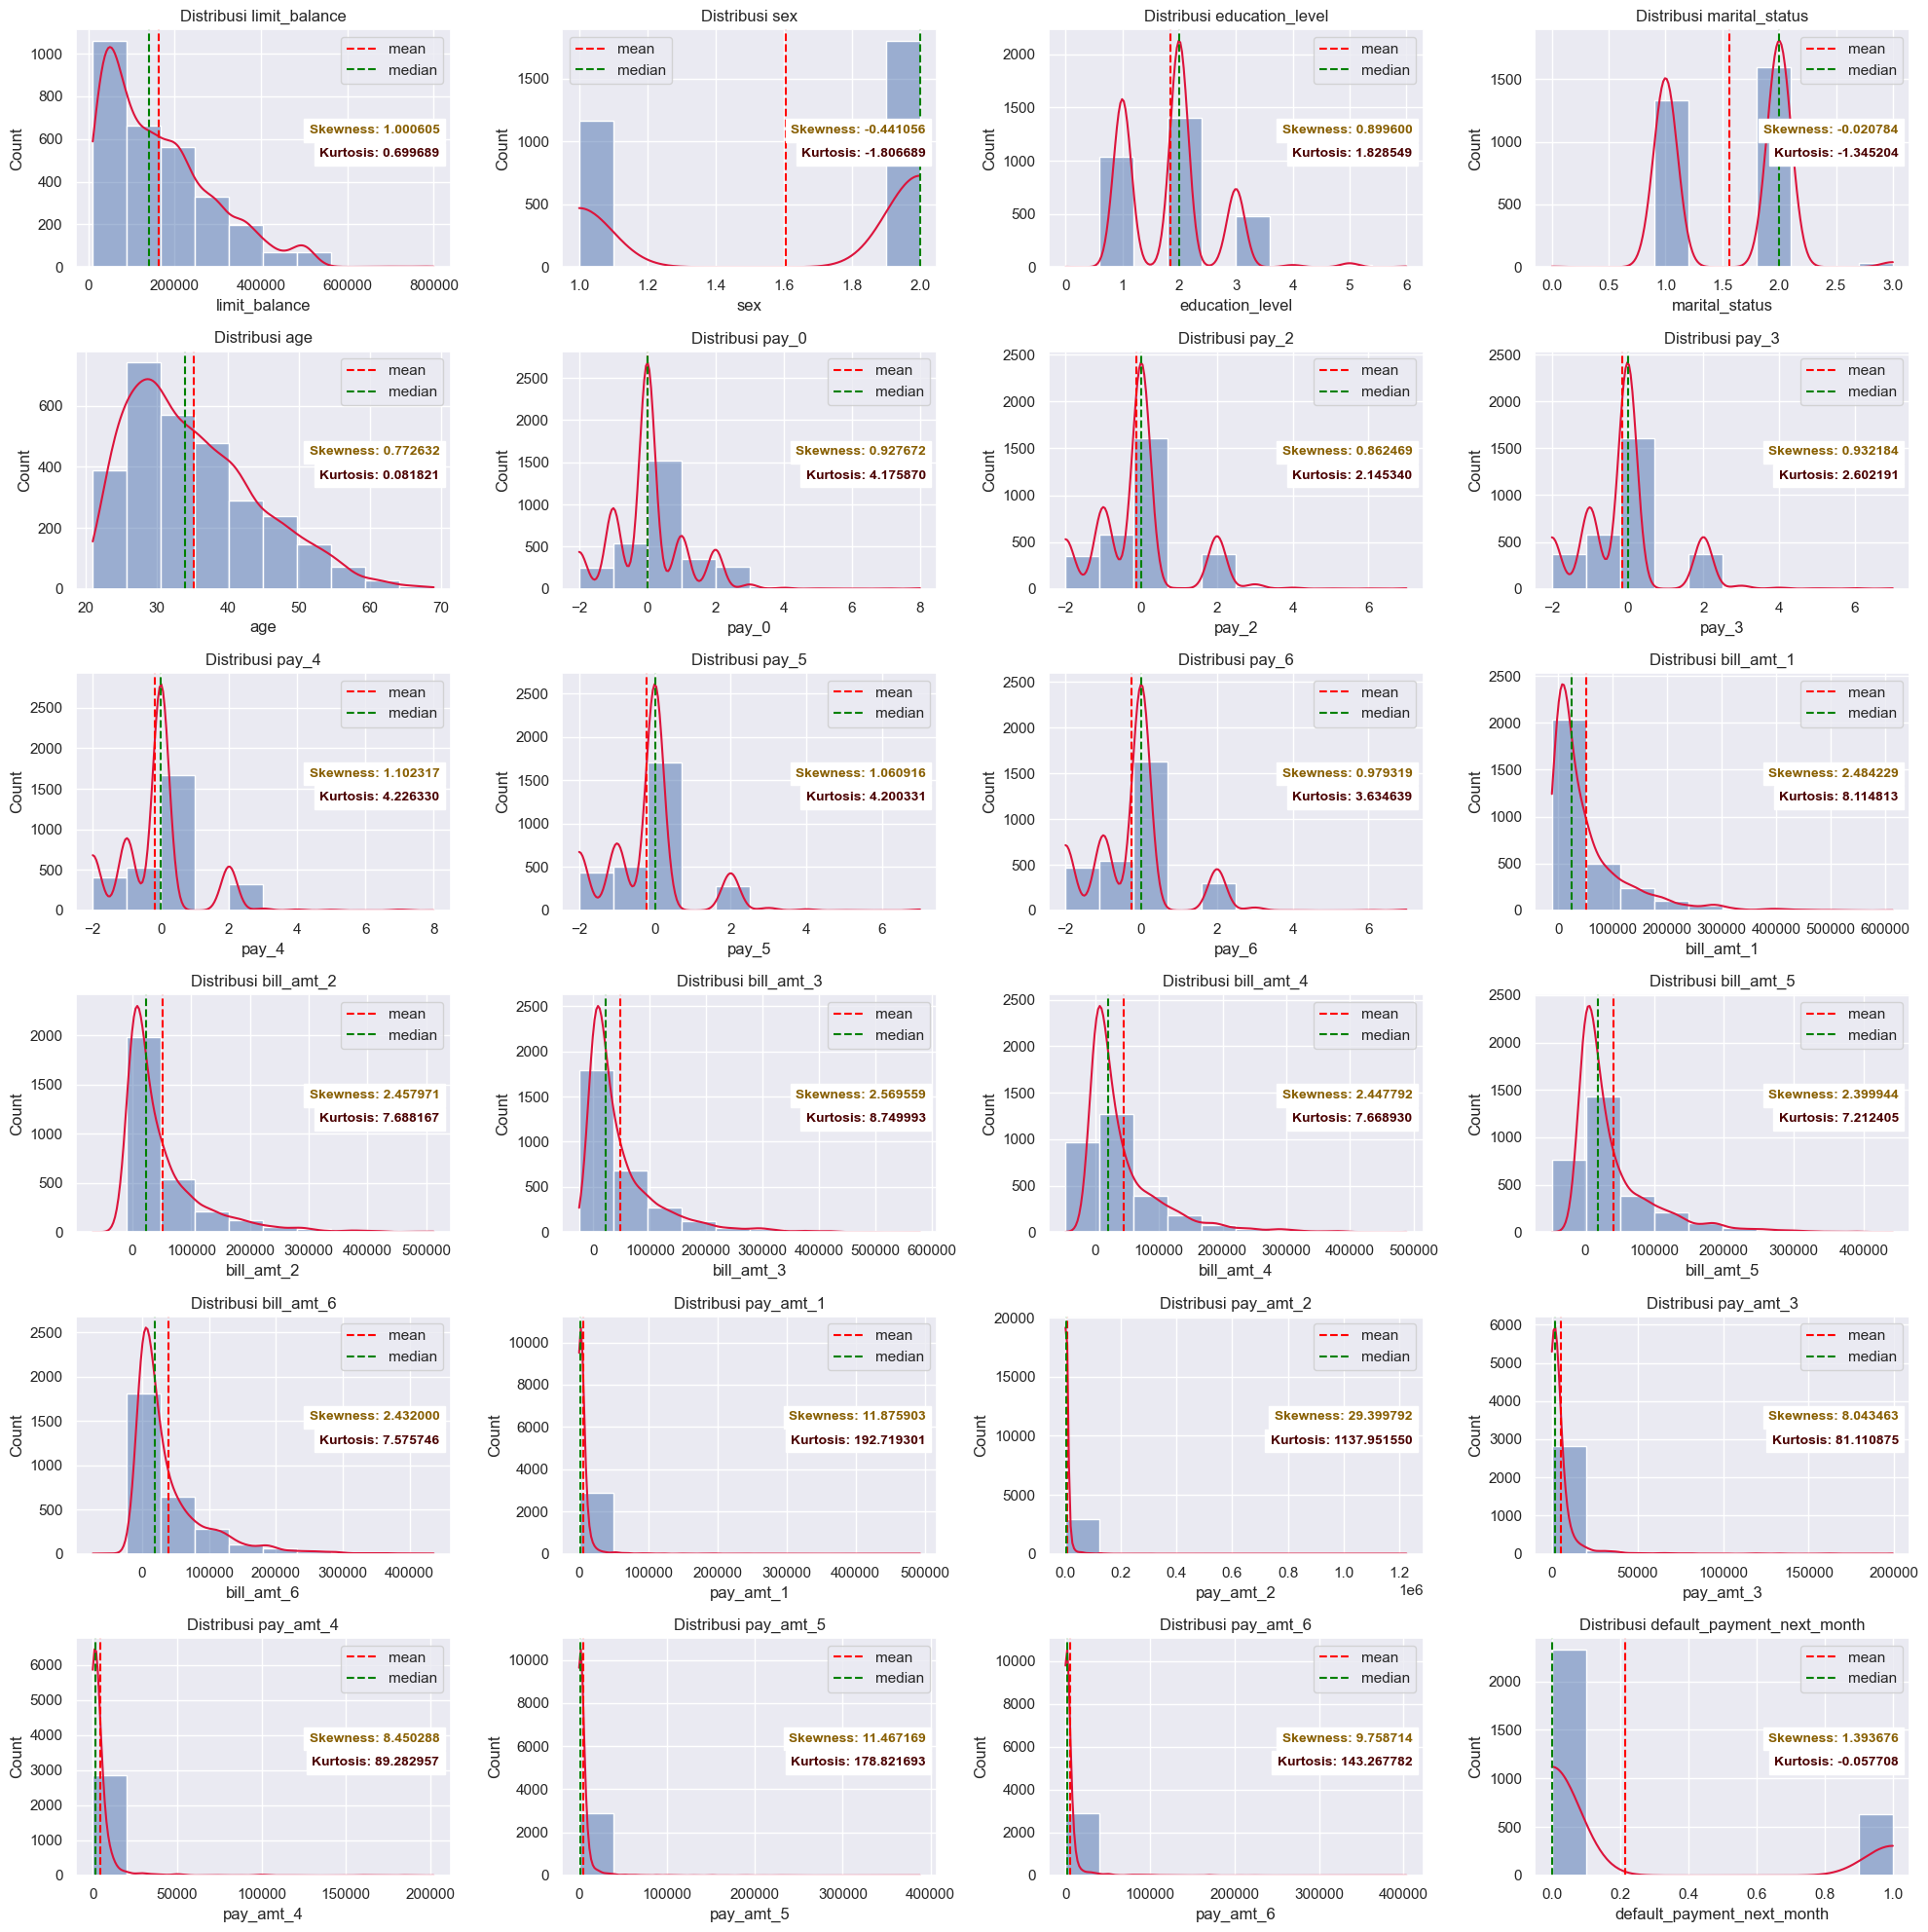

In [17]:
# plot distribusi fitur distance, surge_multiplier, dan price
row_num=6
col_num=4
fig, axes= plt.subplots(row_num,col_num, figsize=(20,20))

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.8)
x=0
for i in range(row_num):
    for j in range(col_num):
        sns.histplot(ax=axes[i][j], data=df[num_col[x]], kde=True, bins=10)
        axes[i][j].set_title(titles[x])
        axes[i][j].lines[0].set_color('crimson')
        axes[i][j].axvline(df[num_col[x]].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
        axes[i][j].axvline(df[num_col[x]].median(), color = 'green', linestyle = 'dashed', label = 'median')
        axes[i][j].legend()
        axes[i][j].text(x=0.97, y=0.60, transform=axes[i][j].transAxes, s="Skewness: %f" % df[num_col[x]].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
        axes[i][j].text(x=0.97, y=0.50, transform=axes[i][j].transAxes, s="Kurtosis: %f" % df[num_col[x]].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
        x+=1
plt.tight_layout()

Data jenis kelamin(`sex`) dan status pernikahan (`marital_status`) memiliki sebaran data normal, untuk sebaran data `pay_n` terdapat kemiringan sedikit namun secara umum masih tergolong normal. Untuk sebaran data `bill_amt_n` secara umum terlihat sangat miring dengan kurtosis yang sangat runcing, dapat dikatakan sebaran datanya relatif terpusat/seragam sedangkan untuk kolom `pay_amt_n` terlihat sebaran datanya yang jauh lebih miring dan lebih runcing dibanding sebaran `bill_amt_n`. Terakhir, untuk distribusi target yakni `default_payment_next_month` terlihat miring namun tidak terlalu runcing [sumber](https://www.smartpls.com/documentation/functionalities/excess-kurtosis-and-skewness/).

## Feature Selection

### Phi_K Correlation Test

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


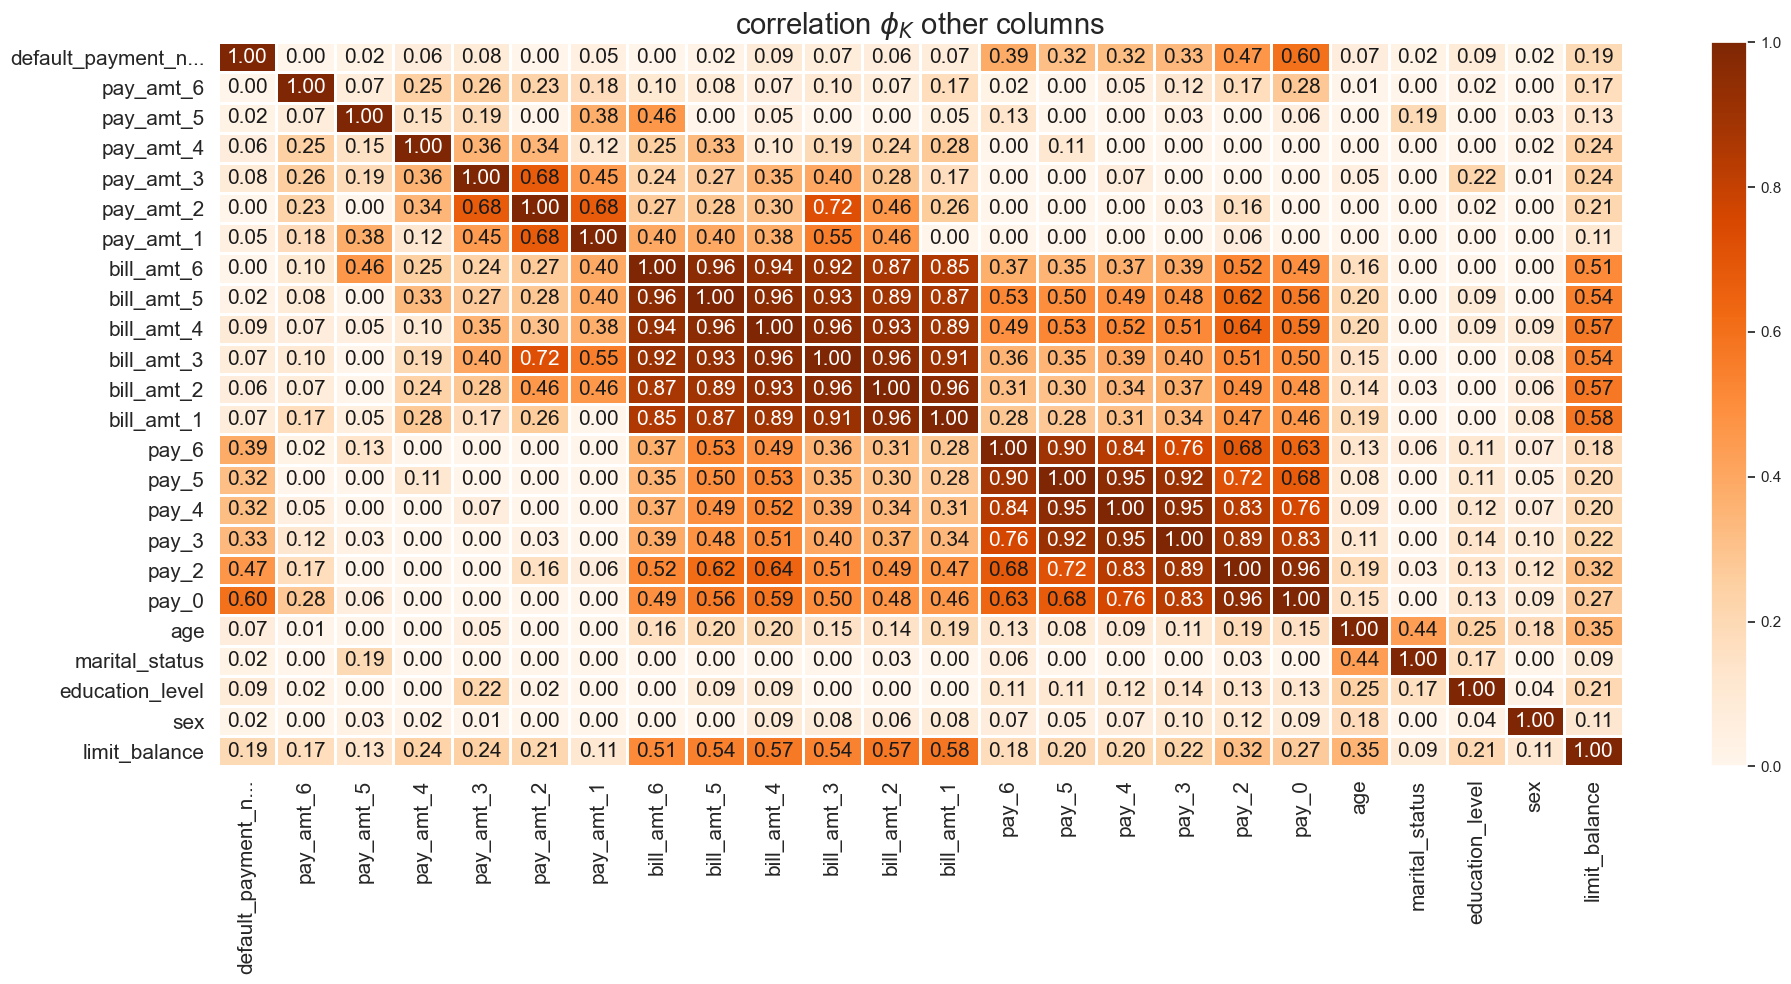

In [18]:
# get the phi_k correlation matrix between all variables
phik_matrix = df.phik_matrix()
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$ other columns", 
                        fontsize_factor=1.5, 
                        figsize=(20,10))
plt.tight_layout()
# sns.heatmap(phik_matrix, annot= True, vmin=0, vmax=1, cmap='Accent', figsize=(12,8))

In [19]:
# cek korelasi yang memiliki signifikansi terhadap default_payment_next_month
df.phik_matrix().default_payment_next_month.sort_values(ascending=False)

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


default_payment_next_month    1.000000
pay_0                         0.596572
pay_2                         0.468335
pay_6                         0.386559
pay_3                         0.334726
pay_4                         0.318688
pay_5                         0.315415
limit_balance                 0.191907
bill_amt_4                    0.087360
education_level               0.085359
pay_amt_3                     0.083774
bill_amt_1                    0.073974
bill_amt_3                    0.073073
age                           0.067038
bill_amt_2                    0.064086
pay_amt_4                     0.062588
pay_amt_1                     0.046866
pay_amt_5                     0.022282
marital_status                0.020055
bill_amt_5                    0.019495
sex                           0.015281
pay_amt_2                     0.004992
bill_amt_6                    0.000000
pay_amt_6                     0.000000
Name: default_payment_next_month, dtype: float64

Dari metrik 𝜙 k (Phik) terlihat ada 2 fitur yang tidak berkorelasi yaitu `bill_amt_6` dan `pay_amt_6`

In [20]:
# menampilkan korelasi berdasakan metode spearman
df.corr().default_payment_next_month.sort_values(ascending=False)

default_payment_next_month    1.000000
pay_0                         0.357185
pay_2                         0.288669
pay_3                         0.275608
pay_4                         0.255648
pay_5                         0.253161
pay_6                         0.237007
education_level               0.044745
age                           0.016883
bill_amt_6                    0.005994
bill_amt_5                    0.005807
bill_amt_2                    0.000751
bill_amt_3                   -0.001200
bill_amt_4                   -0.004844
bill_amt_1                   -0.006089
sex                          -0.021626
marital_status               -0.026193
pay_amt_4                    -0.053748
pay_amt_2                    -0.059307
pay_amt_5                    -0.066214
pay_amt_1                    -0.066221
pay_amt_6                    -0.067025
pay_amt_3                    -0.090318
limit_balance                -0.161868
Name: default_payment_next_month, dtype: float64

Dari metode korelasi spearman, tidak ada fitur yang tidak berkorelasi dengan `default_payment_next_month`, dengan pertimbangan tersebut semua fitur akan digunakan.

In [21]:
# drop fitur yang korelasinya rendah terhadap target
# dropped_features =['bill_amt_6', 'pay_amt_6']

In [22]:
# simpan df dengan fitur yang sudah diseleksi
# df_selected = df.drop(columns=dropped_features)

In [23]:
df_selected = df.copy()

In [24]:
# menampilkan final df dengan fitur yang sudah di seleksi
df_selected.head(3)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,0.0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0


# Data Preprocessing
## Train-Test Split

In [25]:
#split antara fitur dan target
X = df_selected.drop('default_payment_next_month',axis=1)
y = df_selected['default_payment_next_month']

In [26]:
#split antara train dan test dengan cara stratifikasi
data_train, data_test= train_test_split(df_selected, stratify=y,test_size=0.3, random_state=42) # untuk kebutuhan class imbalance handling
X_train1, X_test, y_train, y_test= train_test_split(X, y, stratify=y,test_size=0.3, random_state=42)

print(f'train size: {data_train.shape}')
print(f'test size: {data_test.shape}')

train size: (2074, 24)
test size: (890, 24)


In [27]:
# menampilkan 5 data fitur teratas
data_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1954,150000.0,2,1,2,33.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,24393.0,26847.0,32702.0,33459.0,27800.0,2261.0,27007.0,32715.0,33475.0,27808.0,2261.0,169465.0,0
641,80000.0,2,1,2,25.0,0.0,0.0,0.0,0.0,0.0,0.0,66426.0,55334.0,53738.0,49021.0,45494.0,44218.0,2657.0,1800.0,1799.0,1616.0,1697.0,1737.0,0
1811,80000.0,1,2,1,41.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,3153.0,1013.0,0.0,0.0,2115.0,4264.0,1013.0,0.0,0.0,2115.0,4264.0,0.0,0
267,10000.0,1,2,3,28.0,0.0,0.0,0.0,0.0,0.0,0.0,5757.0,6805.0,7662.0,8034.0,8256.0,8957.0,1300.0,1128.0,500.0,500.0,1000.0,500.0,1
1386,50000.0,1,1,2,28.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,44476.0,45984.0,20972.0,16359.0,1340.0,0.0,2869.0,1527.0,16408.0,1444.0,0.0,0.0,0


In [28]:
# fitur numerik yang akan di scale
scaled_num_col = ['limit_balance','age','bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5','bill_amt_6',\
     'pay_amt_1', 'pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']

## Outlier Handling
Penulis akan melakukan outlier handling terhadap fitur yang telah dipilih, namun sebagaimana [deskripsi](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-izzan&ws=!1m9!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default!1m3!8m2!1s291779957624!2sc1037afa9997464c99b066deab08670b) pada dataset tertera, fitur `pay_n` merupakan representasi data kategorikal yang telah di encode ke bentuk numerikal. Oleh karena itu, penulis hanya akan melakukan trimming pada outlier yang < 3% saja. Penulis tidak akan menggunakan capping dengan alasan akan merusak integritas datanya, namun apabila setelah evaluasi model hasil dirasa kurang memuaskan, maka penulis akan coba menghandle outliernya dengan cara capping/censoring. 

In [29]:
# fungsi untuk membuat histogram dan boxplot dari suatu fitur
def plot_diagnostic(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=10)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1], whis=1.5)
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' is normally distributed".format(col))
    elif df[col].skew() > 0.5 and df[col].skew() <= 1 :
        print("Columns '{}' is moderately right skewed".format(col))
    elif df[col].skew() > 1:
        print("Columns '{}' is highly right skewed".format(col))
    elif df[col].skew() < -0.5 and df[col].skew() >= -1 :
        print("Columns '{}' is moderately left skewed".format(col))
    elif df[col].skew() < -1:
        print("Columns '{}' is highly left skewed".format(col))

In [30]:
# fungsi untuk mendapatkan upper dan lower boundary dari suatu distribusi
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

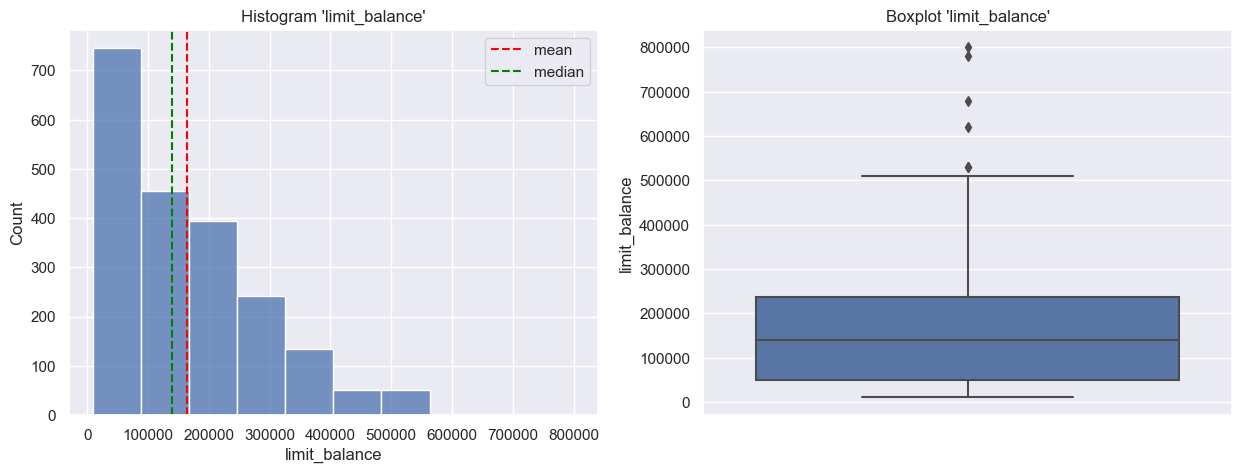

limit_balance Kurtosis: 0.6596589282795606
limit_balance Skewness: 0.9862157758998159
Columns 'limit_balance' is moderately right skewed


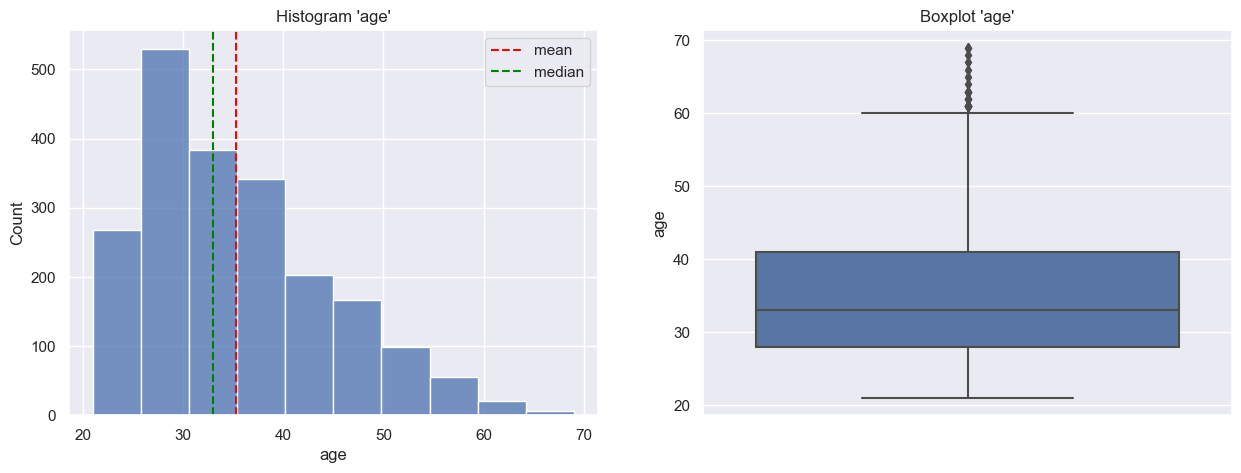

age Kurtosis: 0.08226498457014442
age Skewness: 0.7761710175628765
Columns 'age' is moderately right skewed


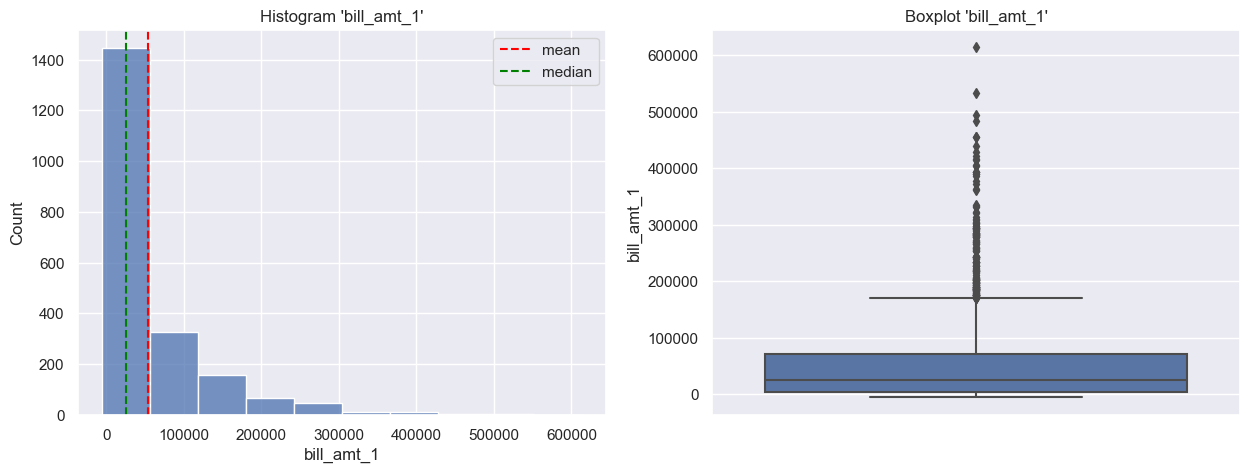

bill_amt_1 Kurtosis: 7.66488252919181
bill_amt_1 Skewness: 2.4565878974465076
Columns 'bill_amt_1' is highly right skewed


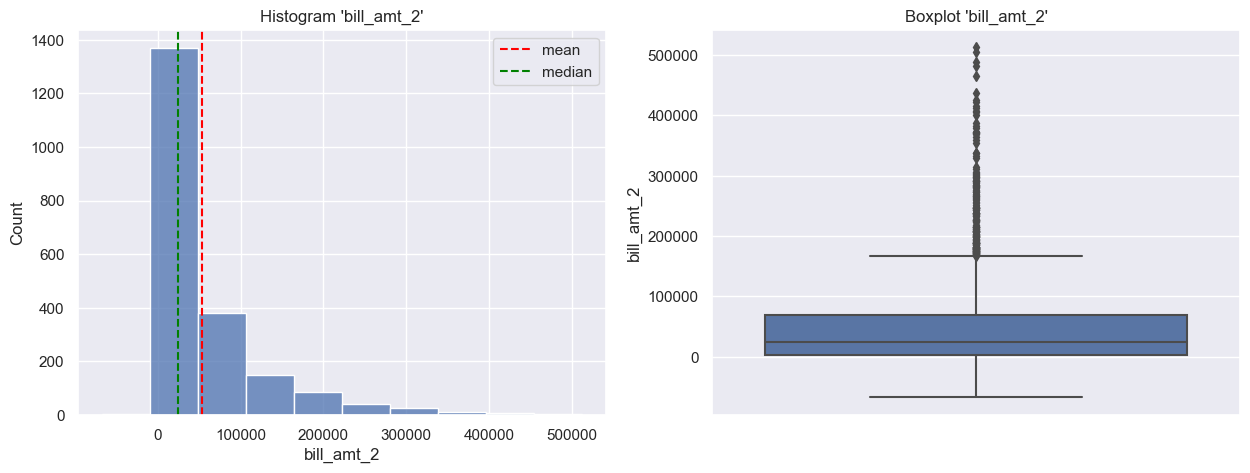

bill_amt_2 Kurtosis: 7.108024432648009
bill_amt_2 Skewness: 2.4131467066683565
Columns 'bill_amt_2' is highly right skewed


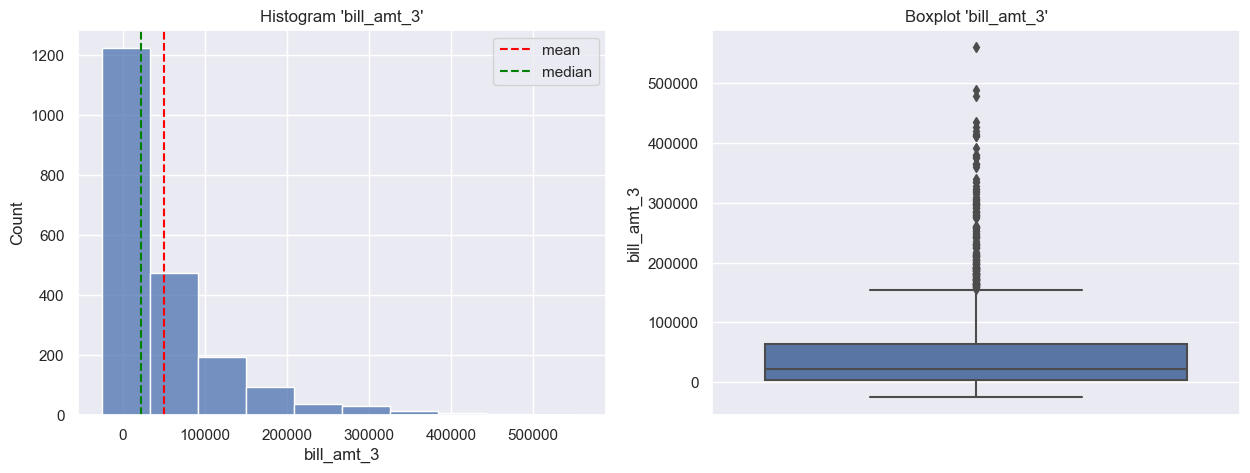

bill_amt_3 Kurtosis: 7.6950848767622135
bill_amt_3 Skewness: 2.4871748589067346
Columns 'bill_amt_3' is highly right skewed


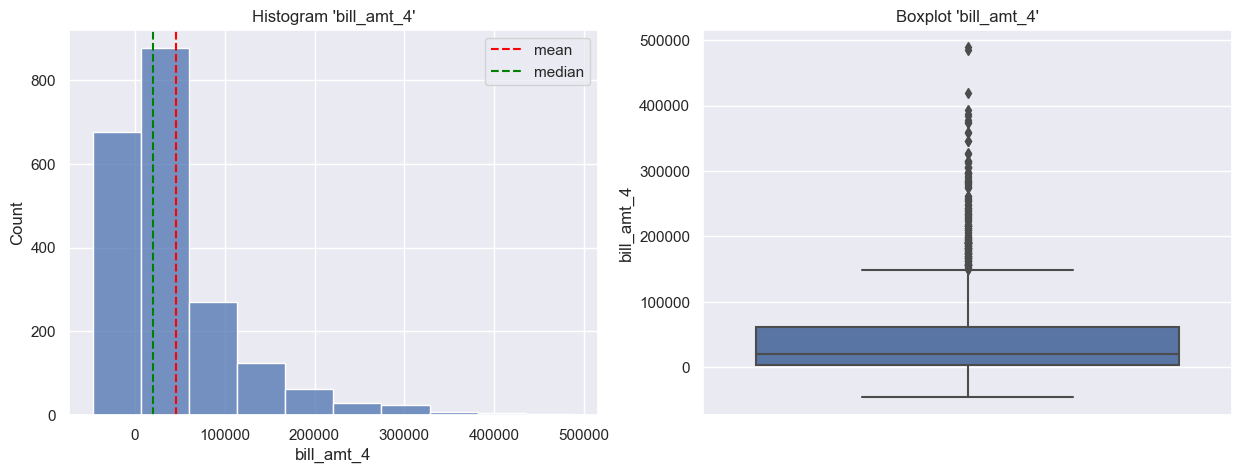

bill_amt_4 Kurtosis: 7.413571141272004
bill_amt_4 Skewness: 2.442240343858705
Columns 'bill_amt_4' is highly right skewed


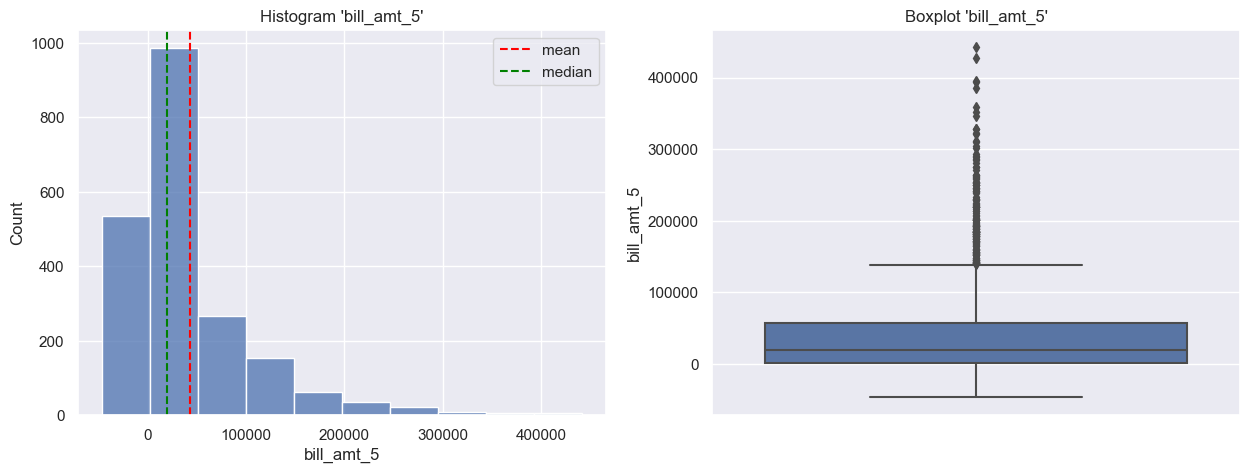

bill_amt_5 Kurtosis: 6.936960359079225
bill_amt_5 Skewness: 2.378983174608857
Columns 'bill_amt_5' is highly right skewed


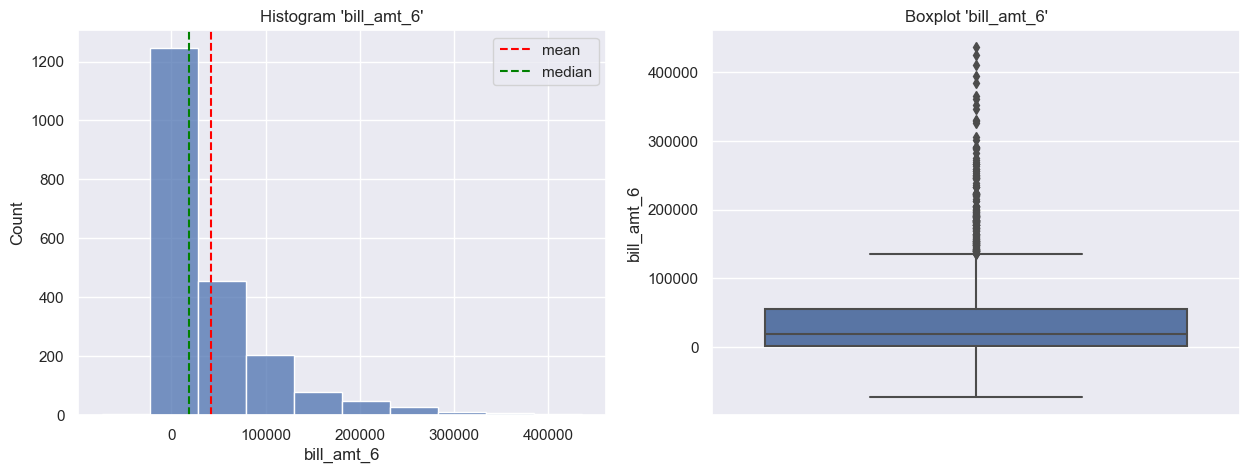

bill_amt_6 Kurtosis: 7.4736284506144885
bill_amt_6 Skewness: 2.4353870411582075
Columns 'bill_amt_6' is highly right skewed


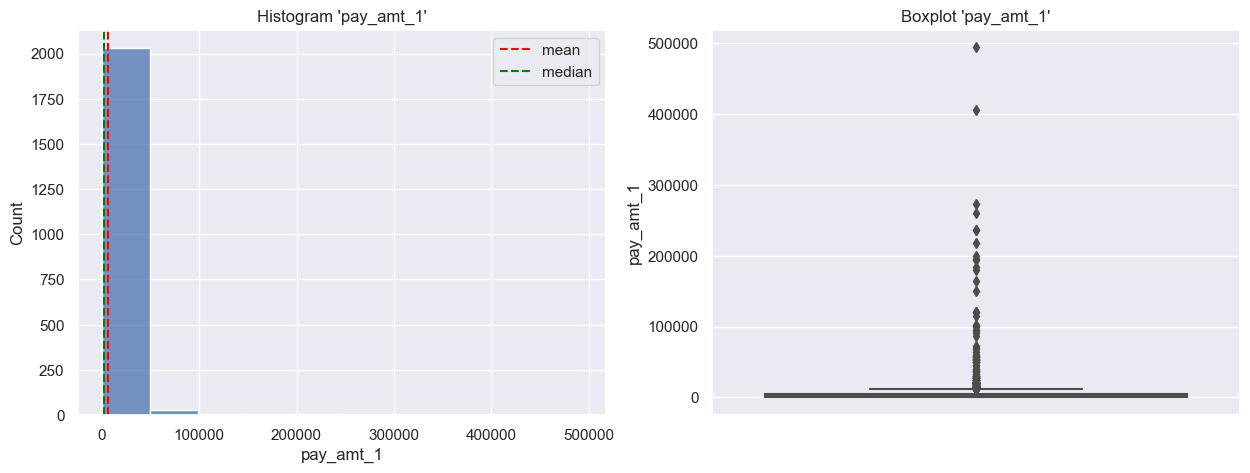

pay_amt_1 Kurtosis: 173.34739606226574
pay_amt_1 Skewness: 11.489941338663005
Columns 'pay_amt_1' is highly right skewed


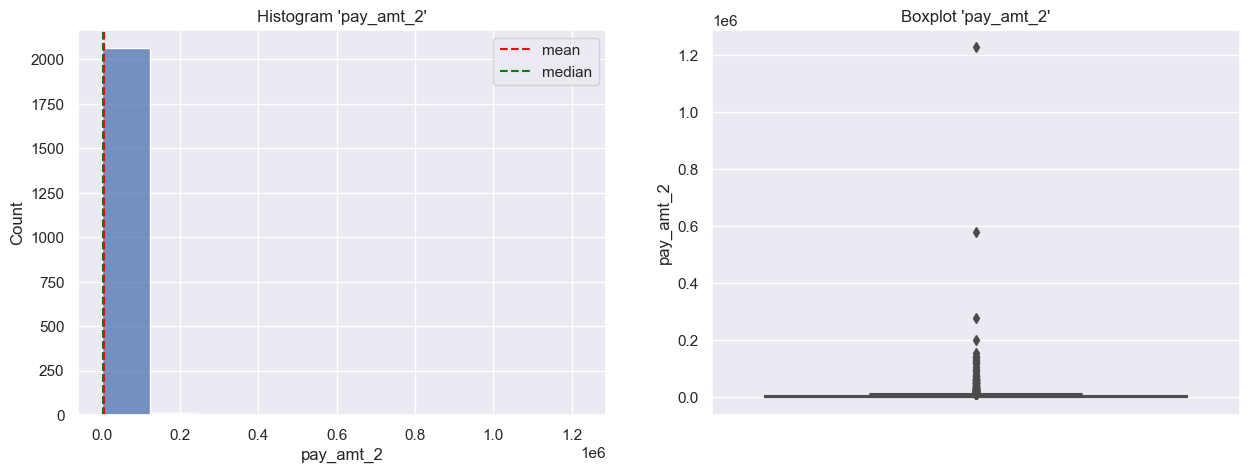

pay_amt_2 Kurtosis: 943.5665457059581
pay_amt_2 Skewness: 27.548489006899256
Columns 'pay_amt_2' is highly right skewed


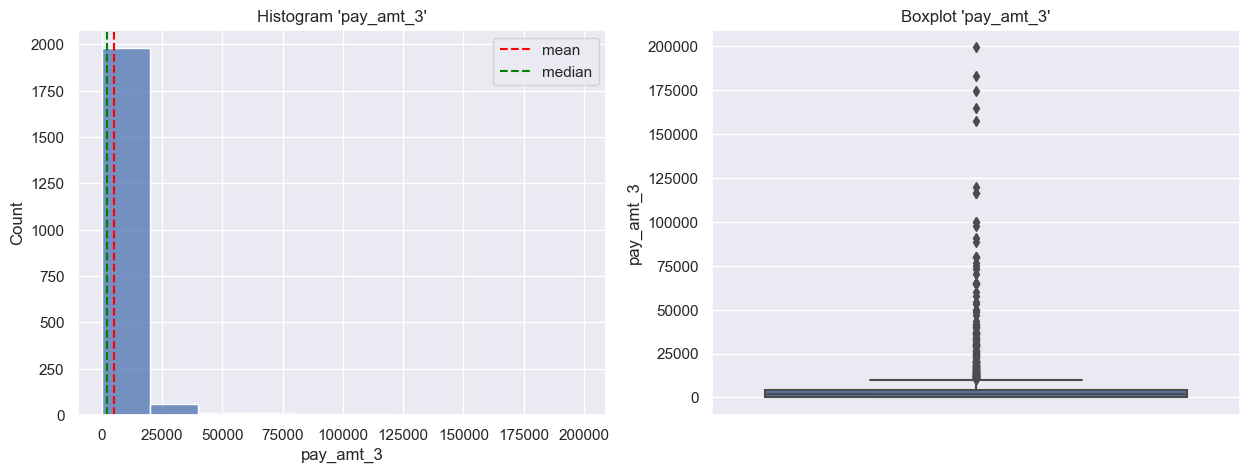

pay_amt_3 Kurtosis: 83.51436265751434
pay_amt_3 Skewness: 7.9958710978962
Columns 'pay_amt_3' is highly right skewed


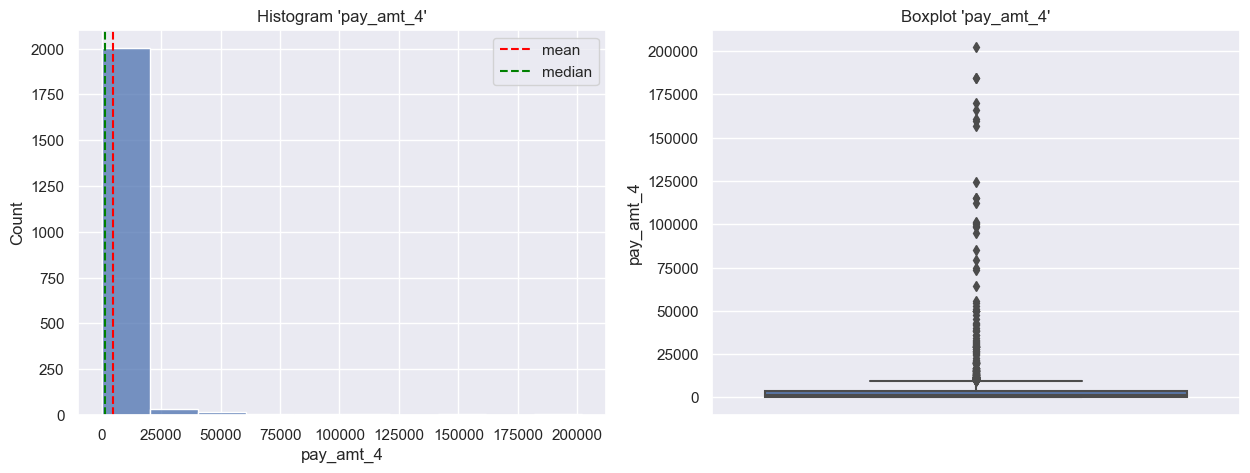

pay_amt_4 Kurtosis: 84.4531388314969
pay_amt_4 Skewness: 8.40884892536404
Columns 'pay_amt_4' is highly right skewed


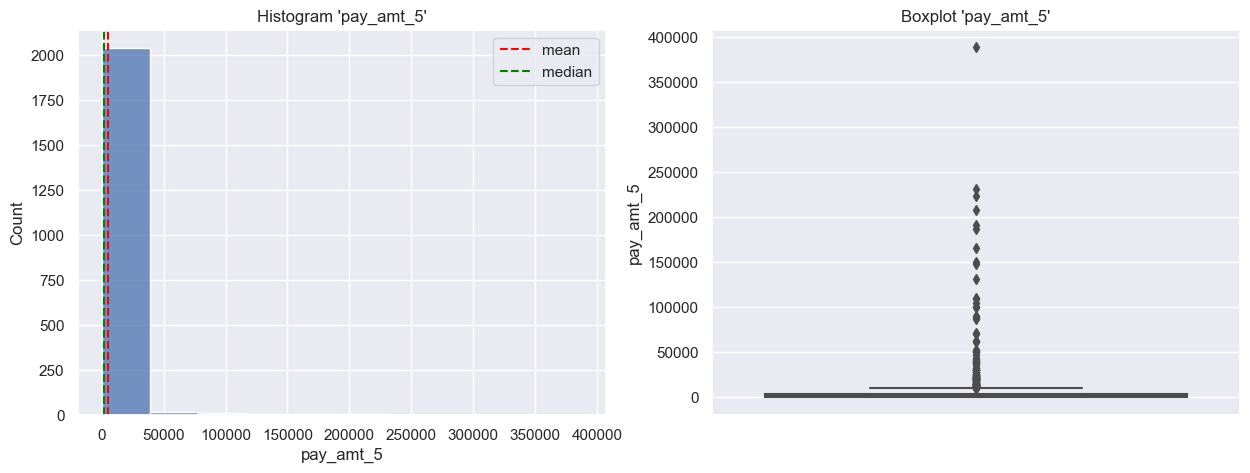

pay_amt_5 Kurtosis: 175.23897914523772
pay_amt_5 Skewness: 11.344945314193403
Columns 'pay_amt_5' is highly right skewed


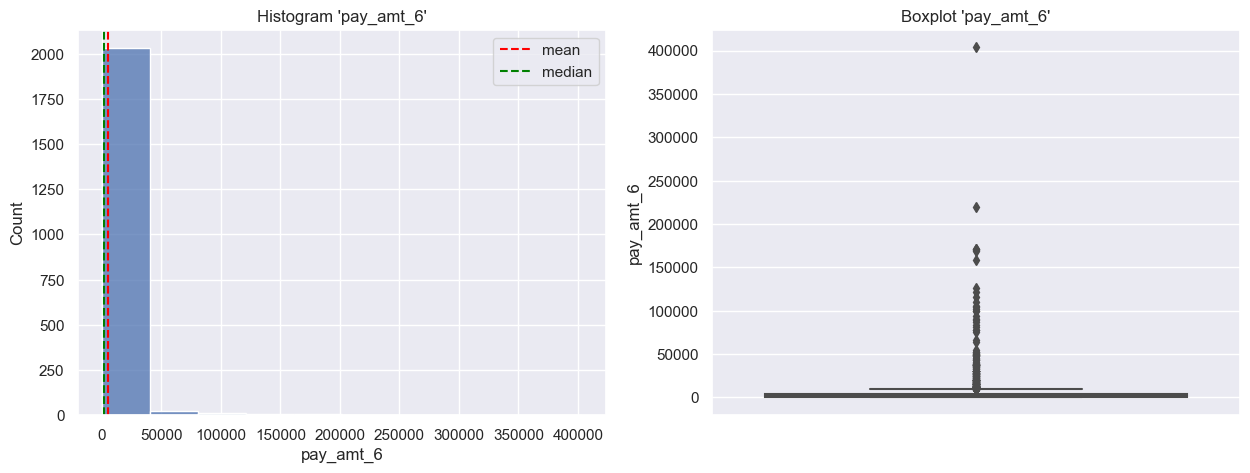

pay_amt_6 Kurtosis: 185.25176902354667
pay_amt_6 Skewness: 11.050407062276802
Columns 'pay_amt_6' is highly right skewed


In [31]:
# plot semua fitur pada data train untuk melihat distribusi sekaligus outliernya
for i in range(len(scaled_num_col)):
    plot_diagnostic(data_train, scaled_num_col[i])

Outlier terdapat pada semua fitur `pay_n` namun karena data numerik fitur `pay_n` merupakan hasil encoding, maka yang diperhatikan hanyalah `limit_ balance`.

In [32]:
# variable container upper dan lower limit semua kolom numerik
upper = []
lower = []

In [33]:
# simpan value upper dan lower ke dalam list yang sudah dibuat sebelumnya
for i in range(len(scaled_num_col)):
    upper_, lower_ = find_skewed_boundaries(df=data_train, variable=scaled_num_col[i], distance=1.5)
    upper.append(upper_)
    lower.append(lower_)

In [34]:
# simpan value upper dan lower ke dictionary sesuai nama fiturnya dengan format (nama_fitur: upper,lower)
low_up_dict = {}
for i in range(len(scaled_num_col)):
    low_up_dict[scaled_num_col[i]]=[lower[i],upper[i]]

In [35]:
# menampilan dicionary lower dan upper limit value suatu fitur
low_up_dict

{'limit_balance': [-231250.0, 518750.0],
 'age': [8.5, 60.5],
 'bill_amt_1': [-95606.25, 170281.75],
 'bill_amt_2': [-94963.125, 167433.875],
 'bill_amt_3': [-88349.375, 156117.625],
 'bill_amt_4': [-85351.0, 149155.0],
 'bill_amt_5': [-80084.5, 138849.5],
 'bill_amt_6': [-78664.5, 135099.5],
 'pay_amt_1': [-5262.625, 11516.375],
 'pay_amt_2': [-5173.125, 11159.875],
 'pay_amt_3': [-5440.875, 10266.125],
 'pay_amt_4': [-5222.75, 9547.25],
 'pay_amt_5': [-5548.875, 10048.125],
 'pay_amt_6': [-5629.625, 9865.375]}

In [36]:
#list containing outliers percentage
trimmed_outliers = []
censored_outliers = []
# menghitung dan menampilkan persentase outlier dari tiap fitur
for i in range(len(scaled_num_col)):
    num_outlier = data_train[scaled_num_col[i]][(data_train[scaled_num_col[i]] > upper[i]) | (data_train[scaled_num_col[i]] < lower[i])].shape[0]
    outlier_percentage = num_outlier/data_train.shape[0]*100
    if (outlier_percentage<5):
        trimmed_outliers.append([scaled_num_col[i],outlier_percentage])
    else:
        censored_outliers.append([scaled_num_col[i],outlier_percentage])

print("Trimmed Outliers Consideration:")
for i in trimmed_outliers:
    print(f'\tPercentage of outlier in \033[1m{i[0]}\033[0m is {i[1]:.2f}%')

print("Censored Outliers Consideration:")
for i in censored_outliers:
    print(f'\tPercentage of outlier in \033[1m{i[0]}\033[0m is {i[1]:.2f}%')

Trimmed Outliers Consideration:
	Percentage of outlier in limit_balance is 0.29%
	Percentage of outlier in age is 1.11%
Censored Outliers Consideration:
	Percentage of outlier in bill_amt_1 is 8.10%
	Percentage of outlier in bill_amt_2 is 8.24%
	Percentage of outlier in bill_amt_3 is 7.96%
	Percentage of outlier in bill_amt_4 is 7.18%
	Percentage of outlier in bill_amt_5 is 7.14%
	Percentage of outlier in bill_amt_6 is 7.43%
	Percentage of outlier in pay_amt_1 is 9.31%
	Percentage of outlier in pay_amt_2 is 9.64%
	Percentage of outlier in pay_amt_3 is 8.82%
	Percentage of outlier in pay_amt_4 is 9.21%
	Percentage of outlier in pay_amt_5 is 7.91%
	Percentage of outlier in pay_amt_6 is 10.37%


### Trimming
Outlier pada `limit balance` dan `age` akan di trim dengan pertimbangan nilai outliernya relatif sedikit yaitu dibawah `5%`

In [37]:
# ambil index outlier fitur limit_balance
outlier_limit_balance_index = data_train.limit_balance[(data_train.limit_balance < low_up_dict['limit_balance'][0]) | (data_train.limit_balance > low_up_dict['limit_balance'][1])].index

# drop outlier pada kolom limit_balance 
data_train.drop(index=outlier_limit_balance_index,inplace=True)

In [38]:
# ambil index outlier fitur age
outlier_age_index = data_train.age[(data_train.age < low_up_dict['age'][0]) | (data_train.age > low_up_dict['age'][1])].index

# drop outlier pada kolom age 
data_train.drop(index=outlier_age_index,inplace=True)

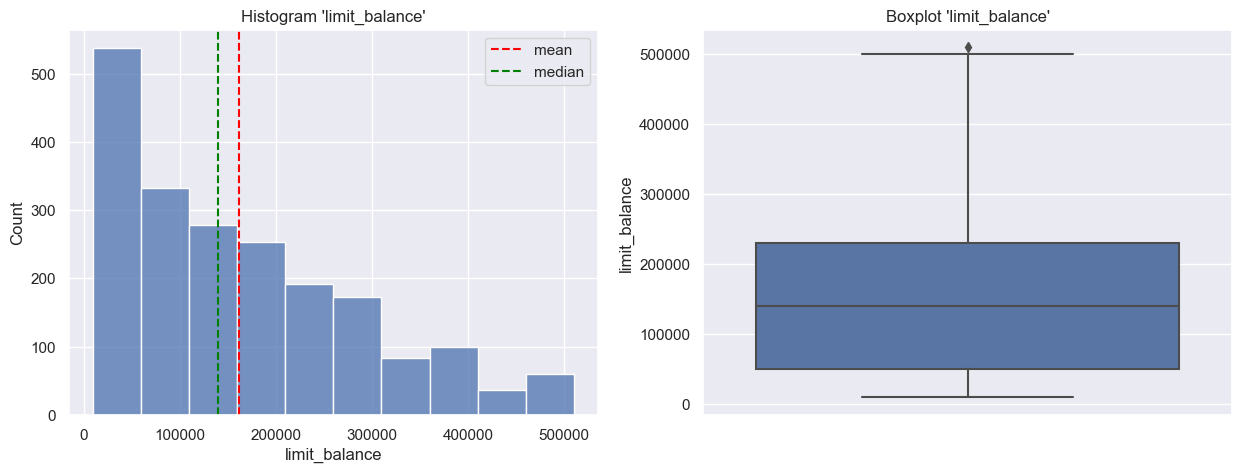

limit_balance Kurtosis: 0.04592491250756714
limit_balance Skewness: 0.8727697860948631
Columns 'limit_balance' is moderately right skewed


In [39]:
# fitur limit_balance setelah dilakukan trimming
plot_diagnostic(data_train, 'limit_balance')

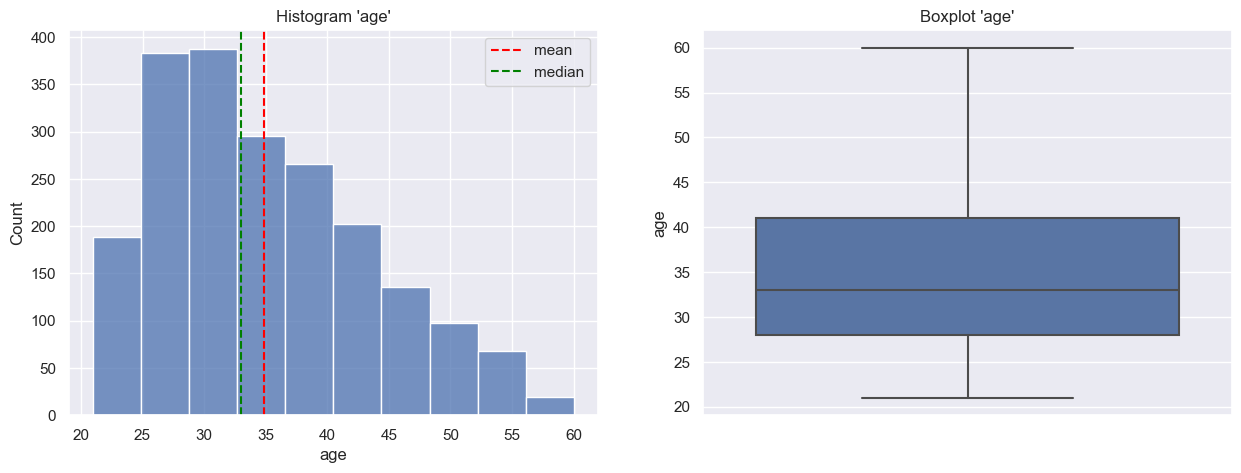

age Kurtosis: -0.36091611400355017
age Skewness: 0.6424436697904765
Columns 'age' is moderately right skewed


In [40]:
# fitur limit_balance setelah dilakukan trimming
plot_diagnostic(data_train, 'age')

### Capping/Censoring
Outlier yang akan di cap adalah outlier yang memiliki jumlah lebih dari `5%` dan akan di *censor/cap* dengan `winsorizer`

In [41]:
# define kolom yang ingin di cap
capped_col = ['bill_amt_1', 'bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',\
    'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']

# Create the capper
windsoriser = Winsorizer(capping_method='iqr',
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=capped_col)

# melakukan capping pada data train
data_train = windsoriser.fit_transform(data_train)

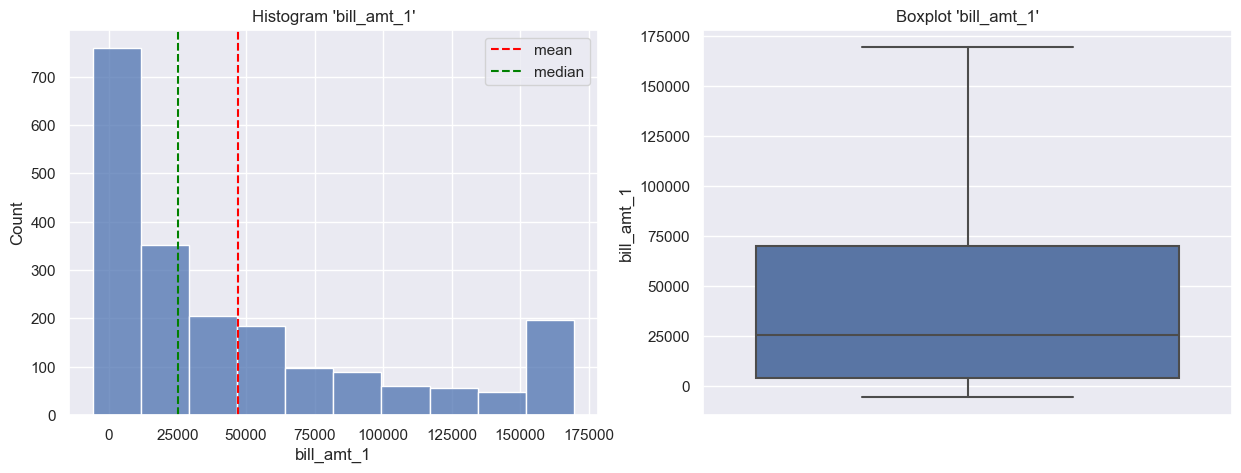

bill_amt_1 Kurtosis: 0.14848437495499933
bill_amt_1 Skewness: 1.1794540795663377
Columns 'bill_amt_1' is highly right skewed


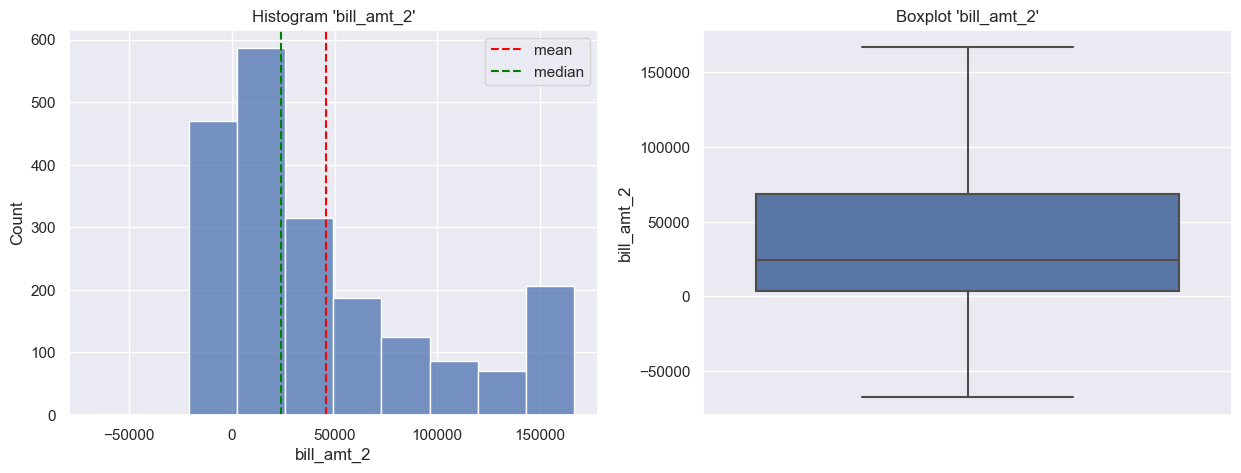

bill_amt_2 Kurtosis: 0.18283582251646457
bill_amt_2 Skewness: 1.1813248041438866
Columns 'bill_amt_2' is highly right skewed


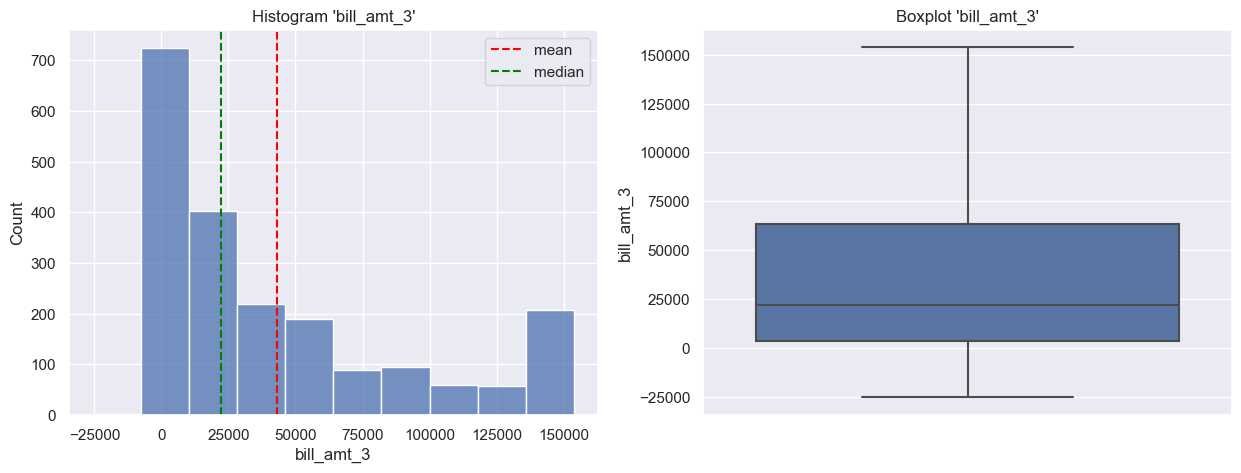

bill_amt_3 Kurtosis: 0.06418276163614944
bill_amt_3 Skewness: 1.1529936640735716
Columns 'bill_amt_3' is highly right skewed


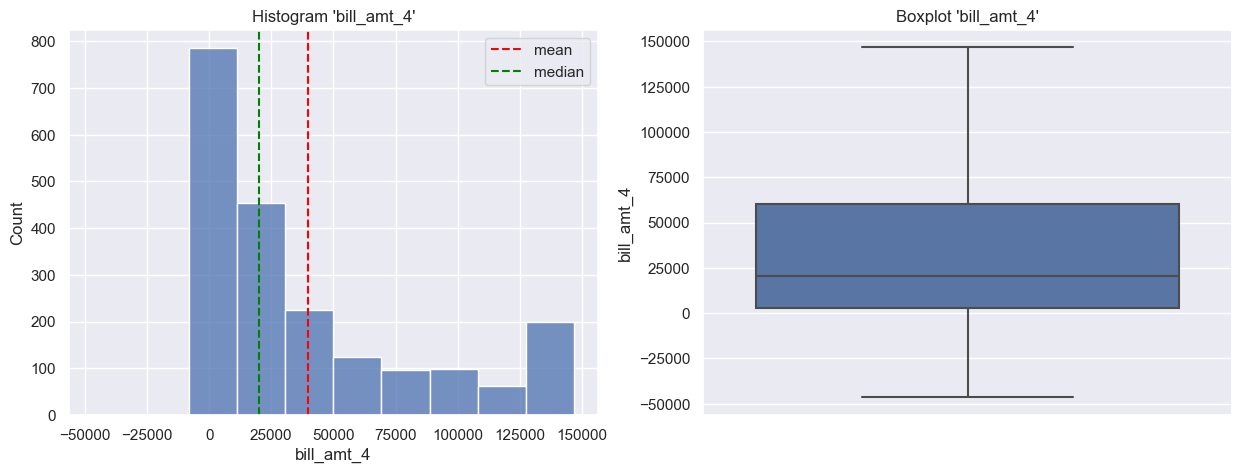

bill_amt_4 Kurtosis: 0.15807482708170406
bill_amt_4 Skewness: 1.1836761341504387
Columns 'bill_amt_4' is highly right skewed


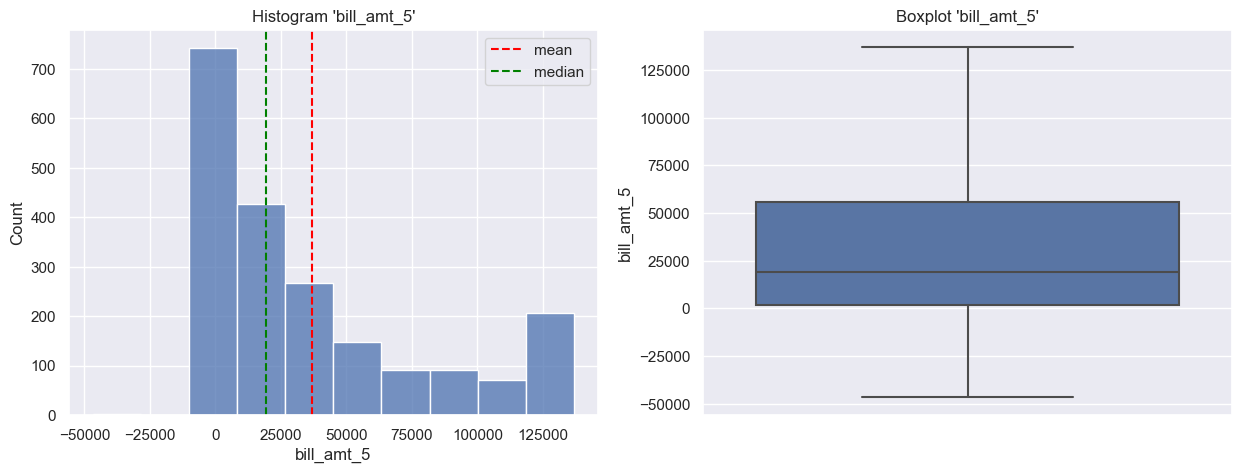

bill_amt_5 Kurtosis: 0.1372131561467862
bill_amt_5 Skewness: 1.1852724276192528
Columns 'bill_amt_5' is highly right skewed


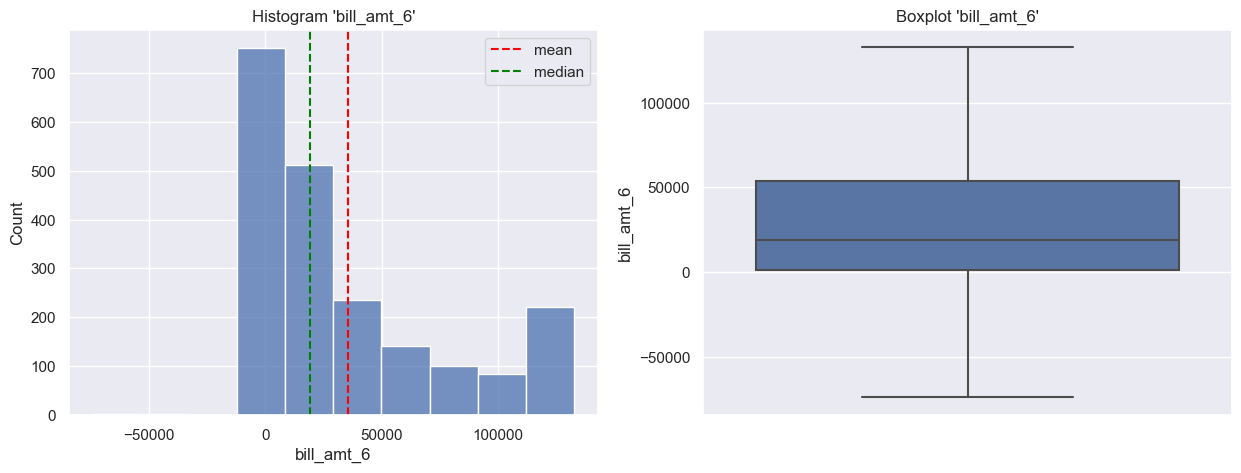

bill_amt_6 Kurtosis: 0.13932725584865535
bill_amt_6 Skewness: 1.1714357673259885
Columns 'bill_amt_6' is highly right skewed


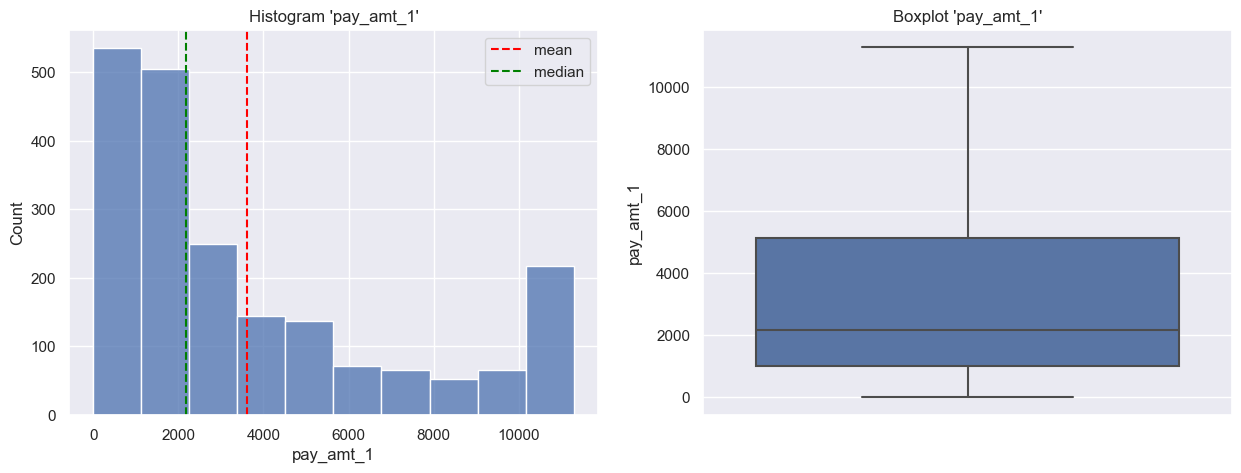

pay_amt_1 Kurtosis: -0.1727790271325329
pay_amt_1 Skewness: 1.0249498735638765
Columns 'pay_amt_1' is highly right skewed


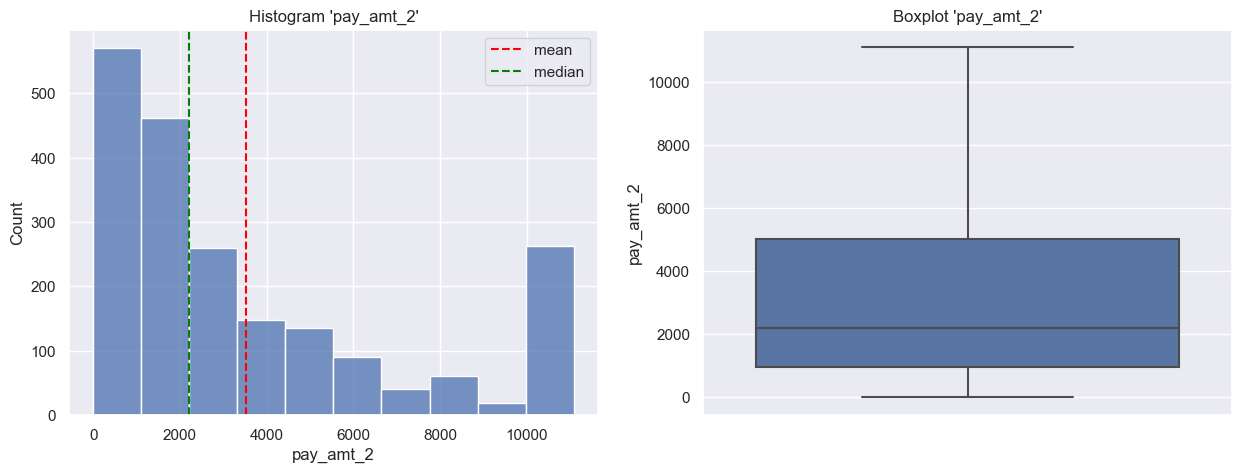

pay_amt_2 Kurtosis: -0.15202127766662699
pay_amt_2 Skewness: 1.03466643039851
Columns 'pay_amt_2' is highly right skewed


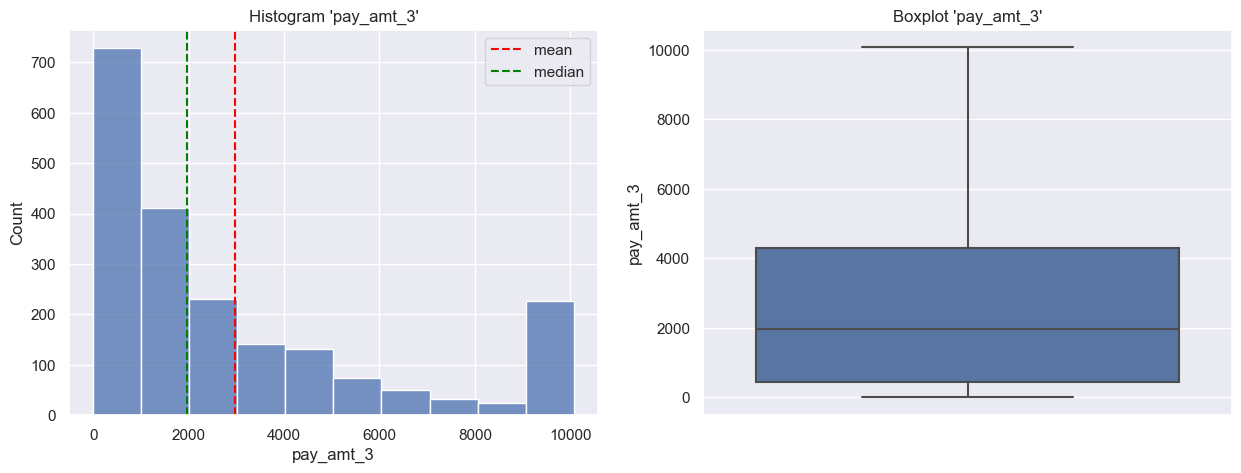

pay_amt_3 Kurtosis: 0.19483282202996355
pay_amt_3 Skewness: 1.1665993124422733
Columns 'pay_amt_3' is highly right skewed


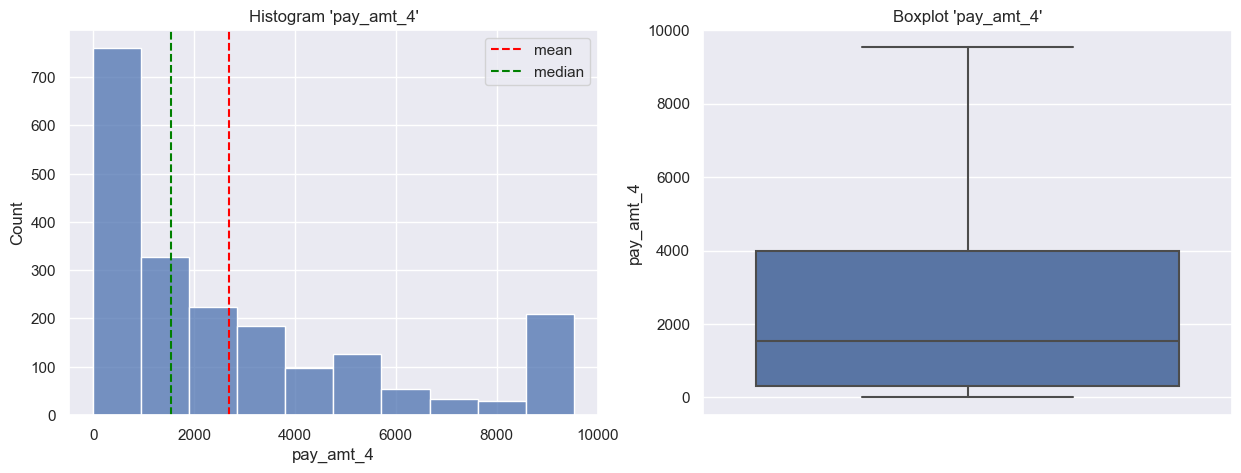

pay_amt_4 Kurtosis: 0.26368549216794257
pay_amt_4 Skewness: 1.1850958618812113
Columns 'pay_amt_4' is highly right skewed


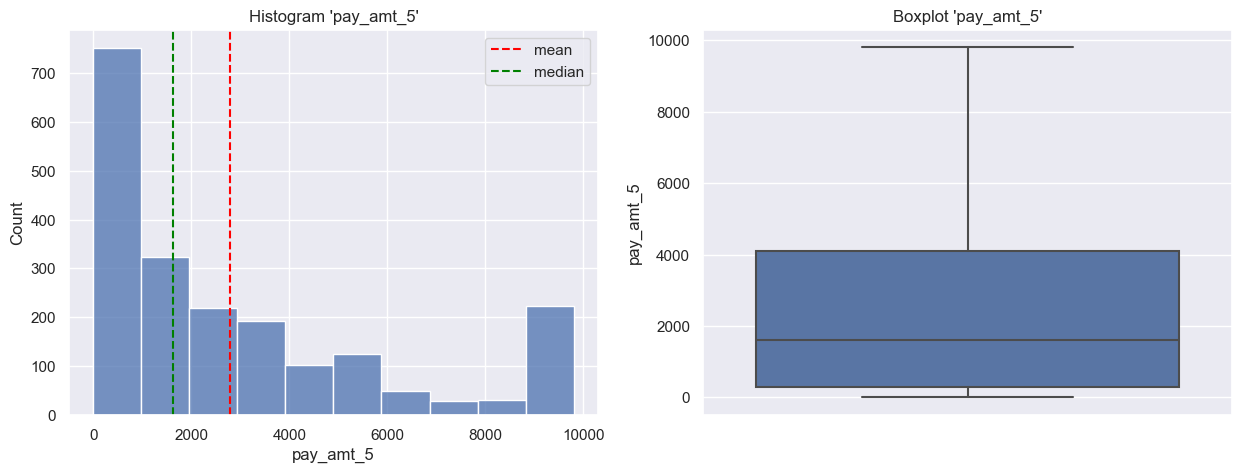

pay_amt_5 Kurtosis: 0.2260851779645492
pay_amt_5 Skewness: 1.1801636685242851
Columns 'pay_amt_5' is highly right skewed


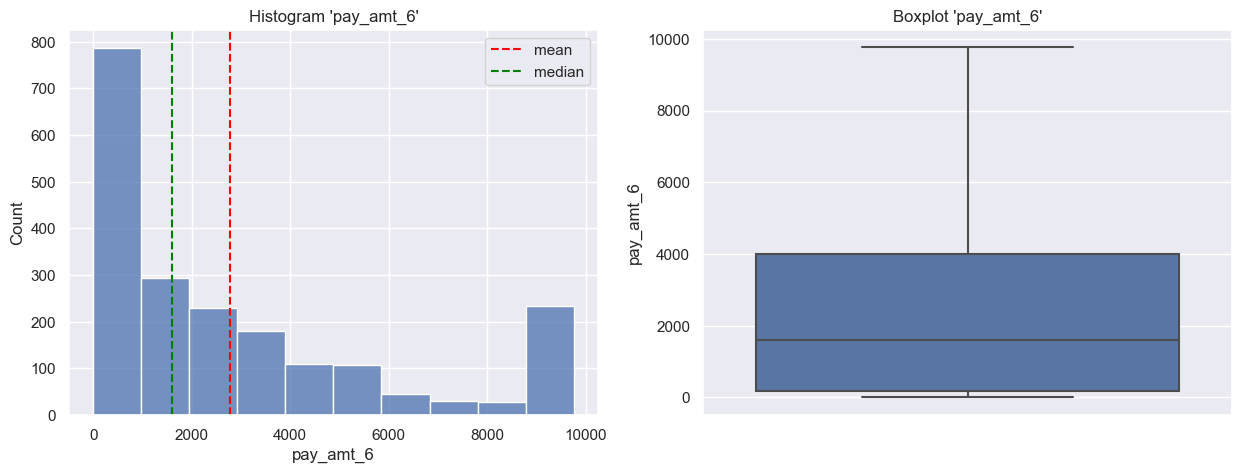

pay_amt_6 Kurtosis: 0.17904766707909214
pay_amt_6 Skewness: 1.1779255462990805
Columns 'pay_amt_6' is highly right skewed


In [42]:
# plot fitur setelah dilakukkan capping
for i in range(len(capped_col)):
    plot_diagnostic(data_train, capped_col[i])

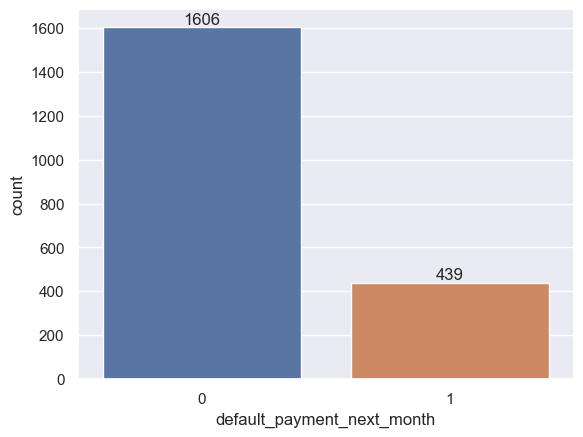

In [43]:
ax = sns.countplot(x=data_train.default_payment_next_month, data=data_train)
ax.bar_label(ax.containers[0])
plt.show()

In [44]:
# original train-test set tanpa class imbalance handling
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_test  = data_test.iloc[:,:-1]
y_test  = data_test.iloc[:,-1]

## Class Imbalance Handling
Pendekatan yang dilakukan untuk class imbalance handling adalah *`upsampling`* dengan teknik SMOTENC dengan pertimbangan fitur pada dataset terdiri dari numerikal dan kategorikal.

In [45]:
data_train.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

In [46]:
# SMOTE
sm = SMOTENC(random_state=42, categorical_features=[1,2,3],sampling_strategy='minority')
X_train_upsampled, y_train_upsampled = sm.fit_resample(X_train, y_train)

In [47]:
# gabungan data train upsampled dengan target
data_train_upsampled = X_train_upsampled.copy()
data_train_upsampled['default_payment_next_month'] = y_train_upsampled

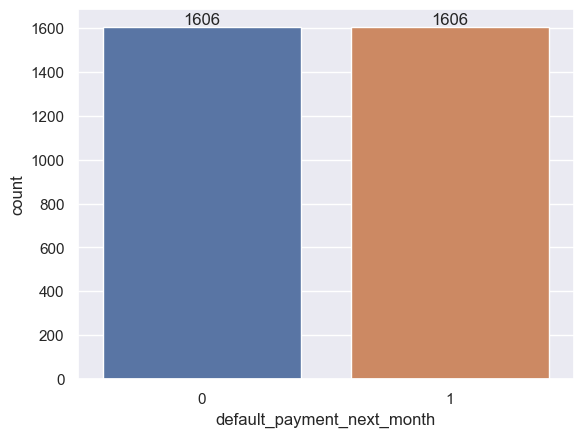

In [48]:
# plot perbandingan jumlah target setelah class imbalance handling
ax = sns.countplot(x=data_train_upsampled.default_payment_next_month, data=data_train_upsampled)
ax.bar_label(ax.containers[0])
plt.show()

## Pipelining
### Scaling & Encoding
- Untuk scaling, penulis akan melakukan scaling pada fitur data numerik kontinu dengan *`minmax scaler`*
- Penulis `tidak` menggunakan `encoding` karena data kategorikal sudah dalam *encoded form*
- Penulis akan membungkus fungsi scaling ini kedalam column transformer dengan variabel bernama *`preprocessor`*

In [49]:
#mendefinisikan kolom/fitur numerik yang akan di transform
numeric_transformer = MinMaxScaler()

# membuat pipeline data preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, scaled_num_col)
    ],
    remainder='passthrough',
)

### Model Definition
Model yang akan digunakan adalah: `Logistic Regression`, `SVM`, `Decision Tree`, `Random Forest`, `KNN`, `Naive Bayes`, `AdaBoost` dan `XGBoost`. Sesuai kriteria Milestone 1, penulis akan melakukan training data pada semua model terlebih dahulu dengan parameter default menggunakan *`cross validation`*. Kemudian model terbaik akan dipilih dan dilakukan `hyperparameter tuning`, dan terakhir `mengevaluasi` performa `sebelum` dan `sesudah` melakukan tuning pada model tersebut.

In [50]:
# instansiasi classifier dengan default parameter
log_model = LogisticRegression()
svm_model = SVC()
tree_model = DecisionTreeClassifier(random_state=42)
rnd_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
ada_model = AdaBoostClassifier()
xgb_model = xgb.XGBClassifier()

Berikut adalah pipeline untuk setiap classifier

In [51]:
# contruct data training pipeline (preprocessing + model fitting)
log_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",log_model)
    ]
)
svm_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",svm_model)
    ]
)
tree_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",tree_model)
    ]
)
rnd_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",rnd_model)
    ]
)
knn_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",knn_model)
    ]
)
nb_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",nb_model)
    ]
)
ada_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",ada_model)
    ]
)
xgb_pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("estimator",xgb_model)
    ]
)

## Model Training & Evaluation
Train data dengan pipeline: preprocessor + estimator yang di cross validate dengan metode *`Stratified KFold`*, dengan pertimbangan target class yang tergolong *`imbalance`*. Untuk metrik evaluasi model, penulis menggunakan *`recall`* dengan pertimbangan meminimalkan angka *`False Negative`* dimana dengan konteks pembayaran cicilan kredit, penulis lebih menekankan pada nasabah yang seharusnya akan *`default payment`* atau gagal bayar (*`default_payment 1=True 0=False`*).

In [52]:
#set metric
metric = 'recall'
n_split = 4

#instansiasi SKFold sebagai teknik cross validation dengan jumlah split tertentu
skfold=StratifiedKFold(n_splits=n_split,random_state=42,shuffle=True)

### Determining Best Model with Cross Validation + Without Class Imbalance Handling

In [53]:
# checking cross validation score
cv_log_model = cross_val_score(log_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_svm_model = cross_val_score(svm_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_tree_model = cross_val_score(tree_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_rnd_model = cross_val_score(rnd_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_knn_model = cross_val_score(knn_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_nb_model = cross_val_score(nb_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_ada_model = cross_val_score(ada_pipe, X_train, y_train, cv=skfold, scoring=metric)
cv_xgb_model = cross_val_score(xgb_pipe, X_train, y_train, cv=skfold, scoring=metric)

name_model = []
cv_scores=0
for cv,name in zip([cv_log_model,cv_svm_model,cv_tree_model,cv_rnd_model,cv_knn_model,cv_nb_model,cv_ada_model,cv_xgb_model],\
    ['log_model','svm_model','tree_model','rnd_model','knn_model','nb_model','ada_model','xgb_model']):
    print(name)
    print(f'{metric} - All - Cross Validation  : ', cv)
    print(f'{metric} - Mean - Cross Validation : ', cv.mean())
    print(f'{metric} - Std - Cross Validation  : ', cv.std())
    print(f'{metric} - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

[22:14:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

### Determining Best Model with Cross Validation + Class Imbalance Handling

In [54]:
# checking cross validation score
cv_log_model = cross_val_score(log_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_svm_model = cross_val_score(svm_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_tree_model = cross_val_score(tree_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_rnd_model = cross_val_score(rnd_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_knn_model = cross_val_score(knn_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_nb_model = cross_val_score(nb_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_ada_model = cross_val_score(ada_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)
cv_xgb_model = cross_val_score(xgb_pipe, X_train_upsampled, y_train_upsampled, cv=skfold, scoring=metric)

name_model = []
cv_scores=0
for cv,name in zip([cv_log_model,cv_svm_model,cv_tree_model,cv_rnd_model,cv_knn_model,cv_nb_model,cv_ada_model,cv_xgb_model],\
    ['log_model','svm_model','tree_model','rnd_model','knn_model','nb_model','ada_model','xgb_model']):
    print(name)
    print(f'{metric} - All - Cross Validation  : ', cv)
    print(f'{metric} - Mean - Cross Validation : ', cv.mean())
    print(f'{metric} - Std - Cross Validation  : ', cv.std())
    print(f'{metric} - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

[22:14:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

### Class Imbalance Handling Effect on Model's Performance

In [55]:
#random forest baseline recall score with test-set (imbalance)
rnd_pipe.fit(X_train,y_train)
y_pred_test = rnd_pipe.predict(X_test)
recall_score(y_test,y_pred_test)

0.3403141361256545

In [97]:
#random forest baseline recall score with test-set (balanced)
rnd_pipe.fit(X_train_upsampled,y_train_upsampled)
y_pred_test = rnd_pipe.predict(X_test)
recall_score(y_test,y_pred_test)
print(f"Random Forest Baseline Model:")
print(f"Recall test set score: {recall_score(y_test,y_pred_test):.2f}")

Random Forest Baseline Model:
Recall test set score: 0.44


In [57]:
#gaussian nb baseline recall score with test-set (imbalance)
nb_pipe.fit(X_train,y_train)
y_pred_test = nb_pipe.predict(X_test)
recall_score(y_test,y_pred_test)


0.4816753926701571

In [98]:
#gaussian nb baseline recall score with test-set (balanced)
nb_pipe.fit(X_train_upsampled,y_train_upsampled)
y_pred_test = nb_pipe.predict(X_test)
recall_score(y_test,y_pred_test)
print(f"Gaussian NB Baseline Model:")
print(f"Recall test set score: {recall_score(y_test,y_pred_test):.2f}")

Gaussian NB Baseline Model:
Recall test set score: 0.58


Dengan class imbalance handling, hasil evaluasi dengan skfold cross validation menunjukkan bahwa model *`Random Forest`*  adalah model terbaik dengan nilai *`recall`* tertinggi sebesar `0.85` terhadap data train yang di *`upsample`*, sedangkan model terbaik tanpa class imbalance handling adalah *`Gaussian Naive Bayes`* dengan recall sebesar *`0.51`*

## Model Tuning
Dari model terbaik yang sudah diketahui yaitu *`Random Forest`*, penulis akan melakukan tuning hyperparameter terhadap model tersebut untuk memaksimalkan metrik guna mendapatkan model yang optimal. Kedua model menggunakan metode *`Random Search`* untuk tuning hyperparameternya dengan menggunakan kombinasi set parameter tertentu dan data train yang sudah di *`upsample`*, namun untuk evaluasi metrik nya menggunakan data test yang `tidak di upsample`. Berdasarkan trial & error penulis, metric tuning `F1-Score` adalah metrik yang terbaik untuk memaksimalkan nilai recall pada test-set.

### Random Forest Model

In [104]:
#define tuning metric
tuning_metric = 'recall'

# tuning hyperparameter random forest model
param_rf = {
    'estimator__n_estimators': [50,100,150],
    'estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'estimator__max_depth': [3,4,5],
    'estimator__min_samples_split':[3,4,5],
    'estimator__min_samples_leaf':[3,4,5],
    'estimator__max_leaf_nodes':[4,5,None],
    'estimator__min_impurity_decrease': np.arange(0, 1, 0.001).tolist(),
    'estimator__ccp_alpha': np.arange(0, 1, 0.001).tolist()
    }

# tuning hyperparameter random forest model
rf_randcv = RandomizedSearchCV(rnd_pipe, param_distributions=param_rf, cv=n_split, scoring=tuning_metric, n_jobs=-1, n_iter=100,random_state=42)
rf_randcv.fit(X_train_upsampled, y_train_upsampled)

# print output hasil random search random forest
print(f"Random Forest Model:")
print(f"Best cross-validation {tuning_metric}: {rf_randcv.best_score_:.2f}")
print(f"{tuning_metric} test set score: {rf_randcv.score(X_test, y_test):.2f}")
print(f"Best parameters: {rf_randcv.best_params_}")

Random Forest Model:
Best cross-validation recall: 0.68
recall test set score: 0.52
Best parameters: {'estimator__n_estimators': 150, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 5, 'estimator__min_impurity_decrease': 0.094, 'estimator__max_leaf_nodes': 5, 'estimator__max_depth': 4, 'estimator__criterion': 'entropy', 'estimator__ccp_alpha': 0.184}


In [105]:
# predict test-set setelah tuning
y_pred_test_rf_randcv = rf_randcv.predict(X_test)

In [106]:
# print recall score terhadap test set setelah tuning
recall_score(y_true=y_test,y_pred=y_pred_test_rf_randcv)

0.5235602094240838

Dari tuning diatas *`Random Forest`* ketika dilakukan prediksi terhadap *test-set* `Random Forest` mendapatkan `0.52`.

### Gaussian NB Model

In [82]:
#define tuning metric
tuning_metric = 'recall'

# tuning hyperparameter random forest model
param_nb = {
    'estimator__var_smoothing': np.arange(0, 1, 0.001).tolist(),
    }

# tuning hyperparameter random forest model
nb_randcv = RandomizedSearchCV(nb_pipe, param_distributions=param_nb, cv=n_split, scoring=tuning_metric, n_jobs=-1, n_iter=100,random_state=42)
nb_randcv.fit(X_train_upsampled, y_train_upsampled)

# print output hasil random search random forest
print(f"Gaussian NB Model:")
print(f"Best cross-validation {tuning_metric}: {nb_randcv.best_score_:.2f}")
print(f"{tuning_metric} test set score: {nb_randcv.score(X_test, y_test):.2f}")
print(f"Best parameters: {nb_randcv.best_params_}")

Gaussian NB Model:
Best cross-validation recall: 0.72
recall test set score: 0.57
Best parameters: {'estimator__var_smoothing': 0.01}


In [78]:
# predict test-set setelah tuning
y_pred_test_nb_randcv = nb_randcv.predict(X_test)

# print recall score terhadap test set setelah tuning
recall_score(y_true=y_test,y_pred=y_pred_test_nb_randcv)

0.5706806282722513

Dari tuning diatas ketika dilakukan prediksi terhadap *test-set* `Gaussian NB` mendapatkan `0.57`.

## Model Comparison (Pre-Tuning vs Post Tuning)
Performa model akan dibandingkan terhadap test-set, model yang dibandingkan adalah `Random Forest` sebelum dan sesudah hyperparameter tuning.

In [79]:
# fit default gaussian nb
rnd_pipe.fit(X_train_upsampled,y_train_upsampled)

# predict random forest baseline
y_pred_train_rf_baseline = rnd_pipe.predict(X_train_upsampled)
y_pred_test_rf_baseline = rnd_pipe.predict(X_test)

# predict random forest hyperparameter tuned
y_pred_train_randcv = rf_randcv.predict(X_train_upsampled)
y_pred_test_rf_randcv = rf_randcv.predict(X_test)

In [100]:
# random forest baseline result
all_reports = {}
baseline_score_reports = {
    'train - precision' : precision_score(y_train_upsampled, y_pred_train_rf_baseline),
    'train - recall' : recall_score(y_train_upsampled, y_pred_train_rf_baseline),
    'train - accuracy' : accuracy_score(y_train_upsampled, y_pred_train_rf_baseline),
    'train - f1_score' : f1_score(y_train_upsampled, y_pred_train_rf_baseline),
    'test - precision' : precision_score(y_test, y_pred_test_rf_baseline),
    'test - recall' : recall_score(y_test, y_pred_test_rf_baseline),
    'test - accuracy_score' : accuracy_score(y_test, y_pred_test_rf_baseline),
    'test - f1_score' : f1_score(y_test, y_pred_test_rf_baseline),
}
all_reports['Baseline (Default Hyperparameter)'] = baseline_score_reports

# random forest random search cv result
rf_randcv_score_reports = {
    'train - precision' : precision_score(y_train_upsampled, y_pred_train_randcv),
    'train - recall' : recall_score(y_train_upsampled, y_pred_train_randcv),
    'train - accuracy' : accuracy_score(y_train_upsampled, y_pred_train_randcv),
    'train - f1_score' : f1_score(y_train_upsampled, y_pred_train_randcv),
    'test - precision' : precision_score(y_test, y_pred_test_rf_randcv),
    'test - recall' : recall_score(y_test, y_pred_test_rf_randcv),
    'test - accuracy_score' : accuracy_score(y_test, y_pred_test_rf_randcv),
    'test - f1_score' : f1_score(y_test, y_pred_test_rf_randcv),
}
all_reports['Random Search Optimization'] = rf_randcv_score_reports
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Random Search Optimization
train - precision,1.000000,0.821091
train - recall,1.000000,0.702989
train - accuracy,1.000000,0.774907
train - f1_score,1.000000,0.757464
test - precision,0.622222,0.487805
test - recall,0.439791,0.523560
test - accuracy_score,0.822472,0.779775
test - f1_score,0.515337,0.505051


### Classification Report
#### Baseline Model

In [65]:
# baseline random forest sebelum tuning terhadap train-set
print(classification_report(y_test,y_pred_test_rf_baseline))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       699
           1       0.62      0.44      0.52       191

    accuracy                           0.82       890
   macro avg       0.74      0.68      0.70       890
weighted avg       0.81      0.82      0.81       890



In [66]:
# baseline gaussian nb sebelum tuning terhadap test-set
print(classification_report(y_test,y_pred_test_rf_randcv))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       699
           1       0.49      0.52      0.51       191

    accuracy                           0.78       890
   macro avg       0.68      0.69      0.68       890
weighted avg       0.79      0.78      0.78       890



### Confusion Matrix

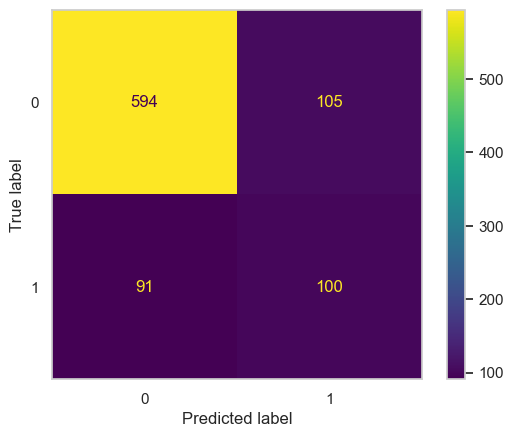

In [67]:
# gaussian nb confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})
cm = confusion_matrix(y_test, y_pred_test_rf_randcv, labels=rf_randcv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_randcv.classes_)

disp.plot()
plt.show()

Hasil true positive sebanyak 240, false positive sebanyak 68, false negative sebanyak 62, dan true negative sebanyak 76. 

# Model Saving

In [99]:
# save model
with open('rf_randcv.pkl','wb') as file_1:
    joblib.dump(rf_randcv,file_1)

with open('nb_randcv.pkl','wb') as file_2:
    joblib.dump(nb_randcv,file_2)

# Conceptual Problems
1. Apa yang dimaksud dengan `criterion` pada Decision Tree ? Jelaskan criterion yang kalian pakai dalam kasus ini !
> Criterion adalah metrik untuk menentukan kualitas split pada tree based model dalam kasus ini yang dipakai adalah `entropy` dimana yang dihitung adalah meminimalkan log loss, namun secara default yang dipakai oleh sklearn adalah `gini` dimana gini impurity adalah peluang elemen yang dipilih disalah labelkan jika secara random dilakukan labeling, semakin rendah gini impurity semakin "pure" atau murni set elemen tsb. Dalam konteks decision tree, tujuannya adalah meminimalkan nilai gini impurity agar leaf node terakhir menjadi yang paling murni/pure.
2. Jelaskan apa yang dimaksud dengan `pruning` pada Tree-based model (alasan, definisi, jenis, dll) !
> Pruning adalah proses menghilangkan cabang/sub-pohon yang tidak banyak berkontribusi pada keseluruhan akurasi model. Tujuan dari pruning untuk meningkatkan kemampuan generalisasi model tersebut dengan cara mengurangi kompleksitasnya. Jenis pruning antara lain: `pre-pruning` dimana metode ini dilakukan dengan memberikan `threshold` atau batas atas jumlah sampel pada leaf node sebelum berhenti bercabang lebih. Selanjutnya ada metode `post-pruning` yang umum dilakukan adalah `error-pruning` dimana setelah tree-based model bercabang secara penuh dari proses training, `branches` atau cabang yang tidak berkontribusi terhadap score akurasi set validasi akan dipotong.
3. Bagaimana cara memilih `K` yang optimal pada KNN ?
> Memilih `K` yang optimal pada KNN dapat dilakukan dengan `Elbow Method` dimana metode ini melibatkan plotting hubungan jumlah K dan `SSE`(Sum of Squared Error). Nilai optimal K ada pada titik `Elbow` nya dimana penurunan error titik selanjutnya sudah tidak terlalu signifikan lagi.
4. Jelaskan apa yang dimaksud dengan `Cross Validation` !
> Cross validation adalah metode untuk mengevaluasi performa model machine learning dengan cara mencacah data train secara seimbang sesuai jumlah splitnya. Proses training akan dilakukan pada data train terhadap satu potongan split sebagai validasi/'test' nya, hal ini dilakukan sampai semua potongan split telah menjadi validasi testnya kemudian, nilai metrik dari setiap proses tersebut akan dirata-rata sebagai hasil evaluasi akhir/cross validation score nya.
5. Apa yang dimaksud dengan metrics-metrics berikut : `Accuracy`, `Precision`, `Recall`, `F1 Score`, dan kapan waktu yang tepat untuk menggunakannya ?
>- `Akurasi` adalah jumlah prediksi yang benar terhadap jumlah semua sample
>- `Precision` adalah jumlah prediksi yang sungguh benar terhadap gabungan jumlah prediksi yang dianggap benar (bisa salah tapi dianggap benar)
>- `Recall` adalah jumlah prediksi yang sungguh benar terhadap gabungan jumlah prediksi yang seharusnya benar(prediksi salah padahal benar)
>- `F1 Score` adalah rata-rata harmonik atau keseimbangan dari precision dan recall
>- Akurasi tepat dipakai saat jumlah kelasnya balance/seimbang.
>- Precision tepat dipakai saat ingin meminimalkan prediksi False Positive
>- Recall tepat dipakai saat ingin meminimalkan prediksi False Negative
>- F1 Score tepat dipakai saat ingin mencari keseimbangan antara Precision dan Recall

# Conclusion
- Model Gaussian Naive Bayes merupakan model terbaik terhadap dataset credit score
- Pipelining membantu mempermudah workflow pembuatan machine learning model
- Metrik evaluasi sangatlah penting untuk disesuaikan dengan konteks suatu data
- Cross Validation dapat digunakan untuk mengetahui machine learning model terbaik
- Hyperparameter tuning dapat dilakukan salah satunya dengan teknik Random Search
- Metrik recall pada kasus ini bertujuan untuk meminimalkan data false negative yang artinya memaksimalkan prediksi seseorang yang sebenarnya memang terindikasi kredit macet 
- Dari perbandingan performa model yaitu baseline random forest hyperparameter optimized random forest, didapati peningkatan performa recall dari 0.44 ke 0.50
- Model masih tergolong underfit dengan alasan model train dan test hanya mendapat skor recall 0.50 dari train setnya 0.68

# Further Improvement
- Mencoba teknik downsampling dan membandingkannya dengan teknik upsampling yang penulis terapkan pada milestone ini.
- Menseleksi fitur lebih ketat dengan multicolinearity test

In [69]:
df.pay_amt_1.min()

0.0

In [70]:
df_selected.columns.to_list()

['limit_balance',
 'sex',
 'education_level',
 'marital_status',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt_1',
 'bill_amt_2',
 'bill_amt_3',
 'bill_amt_4',
 'bill_amt_5',
 'bill_amt_6',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6',
 'default_payment_next_month']